# Анализ лояльности пользователей Яндекс Афиши
- Автор: Ксения Бардакова
- Дата: 13.12.2025

<a id='цели'></a>
### Цели и задачи проекта

<font color='#777778'> **Цель:** Провести исследовательский анализ данных заказов Яндекс Афиши, чтобы помочь команде маркетинга понимать поведение пользователей, а именно:    
   - выявлять перспективных клиентов и предлагать им персонализированные условия
    
   - настраивать рекламу на аудитории с высокой вероятностью возврата
    
   - оптимизировать маркетинговые бюджеты
    
   - повысить общий уровень удержания клиентов.
    
  
**Задачи:** 
 1. Загрузка и знакомство с данными:
   
   - выгрузить из базы данных `data-analyst-afisha` необходимые данные
    
   - *промежуточный вывод* об их объеме, корректности (названия столбцов и их содержимое, пропуски, типы данных и их вид)
    
    
 2. Проверка ошибок в данных и их предобработка:
    
    - корректность типов данных (преобразование при необходимости)
    - пропуски (количество (абсол. и относит), причины их появления, обработка при необходимости) 
    - дубликаты (явные и неявные, нормализация текстовых данных (`snake_case`))
    - *промежуточный вывод* по предобработке данных
    
    
 3. Создание профиля пользователя, в том числе:
    
    - изучить статистические показатели, аномалии
    - фильтрация данных (при необходимости) и статистика обновленного датасета
    - общий *промежуточный вывод* 
 
 
 4. Исследовательский анализ данных. Изучить:
    
    - признаки первого заказа пользователя
    - возвраты пользователей (сделали 2 и > заказов)
    - количественные характеристики заказов (средняя выручка с заказа и среднее количество билетов в заказе)
    - временные характеристики первого заказа, их влияние на возврат пользователя
    - связь признаков пользователя с числом покупок (phi_k)
    
    
 5. Формулировка выводов и рекомендаций
</font>

In [7]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
!pip install phik
from phik import phik_matrix

# 1. Подключаемся к БД

In [8]:
# Установим библиотеки для подключения к базе данных с помощью Python
!pip install sqlalchemy

In [9]:
!pip install psycopg2

In [10]:
from sqlalchemy import create_engine


In [11]:
import os
from dotenv import load_dotenv

load_dotenv()  # Читает данные из файла .env

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

ValueError: invalid literal for int() with base 10: 'None'

# 2. Извлечение результатов SQL-запроса

In [ ]:
query = '''
SELECT user_id
, device_type_canonical
, order_id
, created_dt_msk AS order_dt --дата заказа
, created_ts_msk AS order_ts --дата и время заказа
, currency_code
, revenue
, tickets_count
, created_dt_msk::date - LAG(created_dt_msk::date, 1, NULL) OVER (PARTITION BY user_id ORDER BY created_dt_msk::date) AS days_since_prev --количество дней между этой покупкой и предыдущей. Если пользователь совершал только одну покупку, то в столбце должно быть NULL
, event_id
, event_name_code AS event_name --название мероприятия
, event_type_main
, service_name
, region_name
, city_name
FROM afisha.purchases AS p 
JOIN afisha.events AS e USING(event_id)
JOIN afisha.city AS c USING(city_id)
JOIN afisha.regions AS r USING(region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id 
'''

In [ ]:
df = pd.read_sql_query(query, con=engine)

In [ ]:
df.head(5)

<font color='#777778'>Познакомимся с данными датасета — оценим первые строки (метод `head()`), приверим корректность выгрузки (фильтрация по устройству, без фильмов, две валюты), выведем информацию о датафрейме  методом `info()`: </font>

In [ ]:
# Проверка фильтрации по устройству
print("Типы устройств:", df['device_type_canonical'].unique())

# Проверка исключения фильмов
print("Типы мероприятий, содержащие 'фильм':")
film_events = df[df['event_type_main'].str.contains('фильм', case=False, na=False)]

# Проверка валют
print("Валюты:", df['currency_code'].unique())


In [ ]:
df.info()

<font color='#777778'>Датасет `df`, полученный на основе базы данных `data-analyst-afisha`, содержит *15 столбцов* и *290611 строк*, в которых представлена информация о заказах и мероприятиях Яндекс Афиши только для mobile/desktop устройства, исключены заказы на фильмы.


Можно отметить:
- cтолбцы соответствуют описанию.
- данные хранятся в типах `datetime64[ns]`(2), `float64`(2), `int64`(3), `object`(8).  
- есть *пропуски* в столбце `days_since_prev` - количество дней от предыдущей покупки пользователя, для пользователей с *одной покупкой* — значение пропущено.
    
    
Изучим корректность типов данных:
1. *Тип данных даты и времени (`datetime64[ns]`)*, два столбца:
    - `order_dt`, `order_ts`- дата создания заказа и дата и время создания заказа, соответственно. Тип данных подходит.

    
2. *Числовые значения с плавающей точкой (`float64`)*, два столбца:
    - `revenue` - информация о выручке с заказа, тип данных подходит.
    - `days_since_prev` - количество дней от предыдущей покупки пользователя, NaN для пользователей с одной покупкой. Представлен целыми числами, можно перевести в `int`.

    
3. *Целочисленный тип (`int64`)*, три столбца:
    - `order_id`, `event_id`,`tickets_count` -  для этих данных тип `int64` корректен, однако можно уменьшить разрядность до `int32` или `int16`.

    
4. *Строковые данные (`object`)*, восемь столбцов:
    - `user_id`, `device_type_canonical`, `currency_code`, `event_name`, `vent_type_main`, `service_name`, `region_name`, `city_name` - содержат строковую информацию, тип данных подходит.
    
  

**Промежуточный вывод:** 

Содержимое столбцов соответствует описанию, названия соответствуют `snake_case`.
    
Присутствуют две валюты оплаты ('rub', 'kzt')
    
Коррекция типов данных: 

- `days_since_prev` в `int`
     
- для `order_id`, `event_id`,`tickets_count` уменьшить разрядность до `int32` или `int16`
    
Пропуски есть в столбце `days_since_prev` и являются маркером пользователей с одной покупкой. </font>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

In [ ]:
# Подготовим данные с информацией о курсе тенге к рублю
info_course = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
info_course['data'] = pd.to_datetime(info_course['data'])

# Получим курс для 1 тенге
info_course['curs_per_one'] = info_course['curs'] / 100

# Проверим изменения
info_course.info()
info_course.head()

In [ ]:
# Будем работать с копией df для безопасности
df_rub = df.copy()

In [ ]:
# Присоединяем курс 1 тенге с датой к копии df, рассчитываем новый столбец revenue_rub с выручкой в рублях
df_rub = df_rub.merge(info_course[['data', 'curs_per_one']], left_on = 'order_dt', right_on = 'data', how = 'left')
df_rub['revenue_rub'] = df_rub.apply(lambda row: (row['revenue'] * row['curs_per_one'] 
        if row['currency_code'] == 'kzt' 
        else row['revenue']
    ), axis=1)
df_rub.head()

In [ ]:
# Проверим все ли заказы в тенге конвертировались 
problem_orders = df_rub[(df_rub['currency_code'] == 'kzt') & (df_rub['revenue'] == df_rub['revenue_rub'])]

print(f"Найдено неконвертируемых заказов: {len(problem_orders)}")
display(problem_orders[['order_id', 'order_dt', 'data', 'currency_code', 'revenue', 'curs_per_one', 'revenue_rub']])

Для 6 заказов проблема в нулевой выручке, а не в отсутствии конвертации.

In [ ]:
len(df_rub) == len(df)

In [ ]:
# Удаляем временные столбцы
df_rub = df_rub.drop(columns=['data', 'curs_per_one'])

# Проверяем
print("Столбцы после удаления:")
print(df_rub.columns.tolist())

In [ ]:
df_rub.info()

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [ ]:
# Проверяем пропуски во всех столбцах
print("Пропуски по столбцам:")
print(df_rub.isna().sum().sort_values(ascending=False))

In [ ]:
# Посчитаем пропуски (пользователей с одной покупкой) в столбце days_since_prev  
print(f"Процент пользователей с одной покупкой: {(df_rub['days_since_prev'].isna().sum() / df_rub.shape[0] * 100).round(2)} %")


In [ ]:
# Проведем коррекцию типов данных: days_since_prev в int; 
#df_rub['days_since_prev'] = df_rub['days_since_prev'].astype('Int64')
#df_rub['days_since_prev'] = pd.to_numeric(df_rub['days_since_prev'], downcast='integer')

In [ ]:
# Уменьшаем разрядность для order_id, event_id, tickets_count 
for column in ['order_id','event_id','tickets_count']:
    df_rub[column] = pd.to_numeric(df_rub[column], downcast='integer')

In [ ]:
# Проверим результат коррекции типов данных 
df_rub.dtypes

In [ ]:
df_rub.head()

In [ ]:
#  Считаем количество явных дубликатов в датафрейме до нормализации
print(f'Количество дубликатов в данных: {df_rub.duplicated().sum()}')

In [ ]:
# Проверяем уникальные значения в столбцах
for column in ['tickets_count', 'device_type_canonical', 'currency_code', 'event_type_main', 'service_name', 'region_name', 'city_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(df_rub[column].sort_values().unique())
    print()

In [ ]:
# Приведем к нижнему регистру текстовые данные:
df_rub[['service_name', 'region_name', 'city_name']] = df_rub[['service_name', 'region_name', 'city_name']].apply(lambda x: x.str.lower())

# Проверим количество дубликатов после нормализации
print(f'Количество дубликатов в данных: {df_rub.duplicated().sum()}')

In [6]:
# Проверяем дубликаты по user_id + order_ts - если один пользователь сделал заказ в одну секунду,
# скорее всего, это технический дубликат
duplicates_second = df_rub.duplicated(subset=['user_id', 'order_ts'], keep=False).sum()
print(f"Дубликаты по 'user_id + order_ts':")
print(f"Найдено: {duplicates_second} строк")
print(f"Доля от всех заказов: {(duplicates_second/len(df_rub)):.4f}")
if duplicates_second > 0:
    print(f"Примеры:")
    dup_samples = df_rub[df_rub.duplicated(subset=['user_id', 'order_ts'], keep=False)].head(10)
    display(dup_samples[['user_id', 'order_ts', 'order_id', 'event_id']])

NameError: name 'df_rub' is not defined

Один пользователь не может сделать заказ в одну секунду, поэтому удалим эти технические дубликаты, оставив первую запись. 

In [ ]:
# Сохраняем исходный размер
initial_df_size = len(df_rub)
print(f"Исходное количество строк перед удалением технических дубликатов по user_id + order_ts: {initial_df_size}")

df_clean = df_rub.drop_duplicates(subset=['user_id', 'order_ts'], keep='first')
removed_tech = initial_df_size - len(df_clean)

print(f"Удалено: {removed_tech} строк")
print(f"Осталось: {len(df_clean)} строк")
print(f"Потери: {removed_tech/initial_df_size:.3%}")

In [ ]:
# Более детальная проверка неполных дубликатов
# Определим ключ для проверки. Это все, что должно быть уникально для заказа, кроме технических полей order_id и order_ts
duplicate_subset = ['user_id', 'event_id', 'tickets_count', 'revenue_rub', 'order_dt']

potential_dup_count = df_clean.duplicated(subset=duplicate_subset, keep=False).sum()
print(f"Строк, входящих в группы с потенциальными неполными дубликатами: {potential_dup_count}")
print(f"Доля от данных: {potential_dup_count / len(df_clean):.2%}")

In [ ]:
 # Находим все дублирующиеся группы
duplicate_groups = df_clean[df_clean.duplicated(subset=duplicate_subset, keep=False)]
 # Сортируем для наглядности
duplicate_groups_sorted = duplicate_groups.sort_values(by=duplicate_subset)
print("Примеры групп с потенциальными неполными дубликатами (первые 3 группы):")

# Выведем первую пару строк из нескольких групп
displayed_keys = set()
for idx, row in duplicate_groups_sorted.iterrows():
    key_tuple = tuple(row[col] for col in duplicate_subset)
    if key_tuple not in displayed_keys:
        group = duplicate_groups_sorted[
            (duplicate_groups_sorted[duplicate_subset] == row[duplicate_subset]).all(axis=1)            ]
        display(group.head(2))  # Показываем первые 2 строки группы
        displayed_keys.add(key_tuple)
        if len(displayed_keys) >= 3:
            break

In [ ]:
# Анализируем группы с потенциальными дубликатами
print(f"Количество уникальных групп (по ключу): {duplicate_groups.drop_duplicates(subset=duplicate_subset).shape[0]}")

print("\nРаспределение по устройствам в потенциальных дубликатах:")
device_counts = duplicate_groups['device_type_canonical'].value_counts()
print(device_counts)

print("\nРаспределение по сервисам (service_name) в потенциальных дубликатах:")
service_counts = duplicate_groups['service_name'].value_counts().head(10) 
print(service_counts)


print("\nСтатистика по размерам групп:")
group_sizes = duplicate_groups.groupby(duplicate_subset).size()
print(f"Максимальное число записей в одной группе: {group_sizes.max()}")
print(f"Среднее число записей в группе: {group_sizes.mean():.2f}")
print(f"Медианное число записей в группе: {group_sizes.median()}")
print(f"Распределение: \n{group_sizes.value_counts().sort_index().head(10)}")

**Вывод по обработке неполных дубликатов:**

1. При проверке на неполные дубликаты по ключу `user_id, event_id, tickets_count, revenue_rub, order_dt` было выявлено 86 287 записей (29.7% данных), образующих 33 142 потенциально дублирующиеся группы. Такой объем исключает возможность их простого удаления как технического шума.

2. Анализ типичных групп по этому ключу и общая статистика указывают на природу легитимных повторных транзакций:

- медианный размер группы = 2, средний = 2.6, временной интервал между заказами в примерах групп = ок. 2ч, преобладают покупки с мобильных устройств, явного доминирования одного сервиса нет. Т.е. эти группы могут быть системным явлением.

3. Цель анализа - создание и анализ профиля пользователя. Поэтому сохраним эти записи, чтобы далее изучить паттерны повторных покупок.


Таким образом, удалены только технические дубликаты по `user_id + order_ts`:

- Исходное количество строк перед удалением: 290 611
- Удалено: 170 строк
- Осталось: 290 441 строк
- Потери данных: 0.058% 

In [28]:
# Проверим распределение численных данных и наличие выбросов в столбцах revenue_rub и tickets_count
print('Статистические показатели столбцов revenue_rub и tickets_count:')
df_clean[['revenue_rub', 'tickets_count']].describe()

Статистические показатели столбцов revenue_rub и tickets_count:


,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571987,2.754311
std,875.498172,1.170620
min,-90.760000,1.000000
25%,113.970000,2.000000
50%,351.140000,3.000000
75%,802.050000,4.000000
max,81174.540000,57.000000


Распределение значений **выручки** асимметричное, скошенное вправо: об этом говорит разница среднего (556) и медианного (351) значений, что, указывает на *выбросы* в данных. Также значение стандартного отклонения довольно высокое (876), что указывает на *большой разброс данных*. *Отрицательные значения* выручки могут указывать на *возвраты*. 

Распределение значений **количества купленных билетов** близкое к нормальному: об этом говорит близость среднего (2.8) и медианного (3.0) значений. Однако, значение стандартного отклонения довольно высокое (1.2) и это указывает, что данные могут иметь *широкий разброс*. Разница между минимальным и максимальным значениями это подтверждает.

Сначала проанализируем выбросы для выручки: 

In [29]:
# Вычисляем квартили Q1 и Q3, межквартильный размах IQR, верхний порог для выбросов (99 перцентиль):
Q1 = df_clean['revenue_rub'].quantile(0.25)
Q3 = df_clean['revenue_rub'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = df_clean['revenue_rub'].quantile(0.99)

print(f"Q1 (25%): {Q1}")
print(f"Q3 (75%): {Q3}")
print(f"IQR: {IQR}")
print(f"Верхний порог выбросов: {upper_bound}")

# Считаем выбросы
outliers = df_clean[df_clean['revenue_rub'] > upper_bound]
print(f"Количество выбросов: {len(outliers)}")
print(f"Максимальное значение среди выбросов: {outliers['revenue_rub'].max()}")

# Расчет процента выбросов
total_num = df_clean['revenue_rub'].count()  
percentage_outliers = (len(outliers) / total_num) * 100

print(f"Процент выбросов среди всех значений: {percentage_outliers:.2f}%")

Q1 (25%): 113.97
Q3 (75%): 802.05
IQR: 688.0799999999999
Верхний порог выбросов: 2628.4217390400004
Количество выбросов: 2825
Максимальное значение среди выбросов: 81174.54
Процент выбросов среди всех значений: 0.97%


Таким образом, основная часть заказов имеет выручку до 2628 рублей.

**Выбросы** (0.97% или 2825 заказов): заказы от 2628 до 81 174 рублей.

Пик распределения (**50% данных**): 114-802 рублей 

Построим гистограмму распределения значений и диаграмму размаха для столбца `revenue_rub`

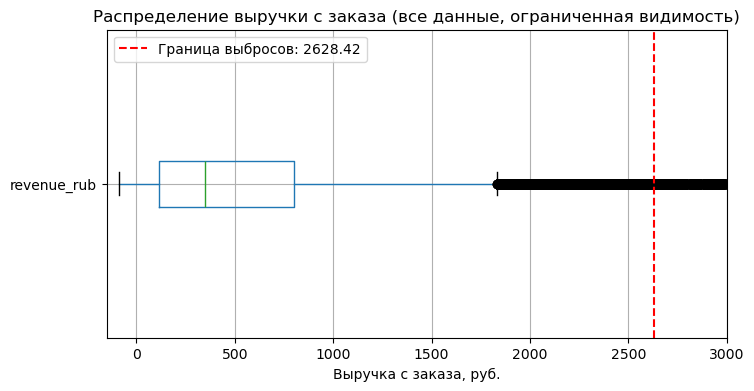

In [30]:
# Строим диаграмму размаха на всех данных, но ограничиваем ось X для лучшей видимости
df_clean.boxplot(column='revenue_rub', vert=False, figsize=(8,4), grid=True)

plt.xlim(-150, 3000)  # Показываем только заказы до 3000 для видимости основной массы точек
plt.axvline(upper_bound, color='red', linestyle='--', 
           label=f'Граница выбросов: {upper_bound:.2f}')

plt.title('Распределение выручки с заказа (все данные, ограниченная видимость)')
plt.xlabel('Выручка с заказа, руб.')
plt.legend()
plt.show()

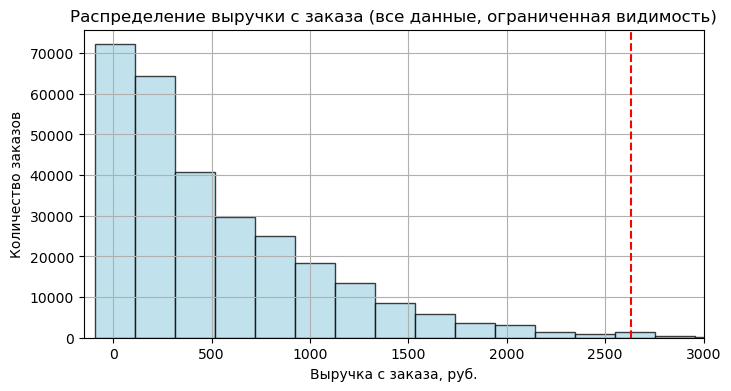

In [31]:
plt.figure(figsize=(8, 4))

df_clean['revenue_rub'].plot(
                kind='hist', 
                bins= 400, 
                color='lightblue',
                alpha=0.75,
                edgecolor='black'
)

# Настраиваем оформление графика
plt.title('Распределение выручки с заказа (все данные, ограниченная видимость)')
plt.ylabel('Количество заказов')
plt.xlabel('Выручка с заказа, руб.')

plt.xlim(-150, 3000)  # Показываем только заказы до 3000 для видимости основной массы точек
plt.axvline(upper_bound, color='red', linestyle='--', 
           label=f'Граница выбросов: {upper_bound:.2f}')

plt.grid()

plt.show()

Отфильтруем выбросы - заказы с большими суммами выручки (выше 99 перцентиля).

In [32]:
df_filt = df_clean[df_clean['revenue_rub'] <= upper_bound]

print("Статистика до удаления выбросов:")
df_clean['revenue_rub'].describe()

Статистика до удаления выбросов:


count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [33]:
print("Статистика отфильтрованного датафрейма:")
df_filt['revenue_rub'].describe()

Статистика отфильтрованного датафрейма:


count    287786.000000
mean        518.029224
std         511.963780
min         -90.760000
25%         111.850000
50%         343.850000
75%         788.660000
max        2628.421739
Name: revenue_rub, dtype: float64

In [34]:
# Проверим отрицательные значения в revenue_rub
negative_revenue = df_filt[df_filt['revenue_rub'] < 0]
print(f"Отрицательных значений в revenue_rub: {len(negative_revenue)}")
print(f"Минимальное значение: {negative_revenue['revenue_rub'].min():.2f}")
print("\nПримеры заказов с отрицательной выручкой:")
display(negative_revenue[['order_id', 'revenue_rub', 'tickets_count', 'event_type_main', 'service_name']].head(15))

Отрицательных значений в revenue_rub: 381
Минимальное значение: -90.76

Примеры заказов с отрицательной выручкой:


,order_id,revenue_rub,tickets_count,event_type_main,service_name
252,1594653,-2.37,3,другое,билеты без проблем
4530,2360920,-0.23,3,другое,билеты без проблем
4546,2361094,-0.15,2,другое,билеты без проблем
8138,166809,-0.62,1,другое,лучшие билеты
8139,166780,-1.86,3,другое,лучшие билеты
11342,6620527,-1.58,2,другое,билеты без проблем
11343,6620498,-1.58,2,другое,билеты без проблем
11566,8333963,-6.18,4,спорт,билеты в руки
11619,4930755,-3.59,1,другое,билеты в руки
11622,8350029,-10.77,3,другое,билеты в руки


In [35]:
# Проверим является ли название билетного оператора или тип мероприятия маркером заказа с отрицательной выручкой
print('Типы мероприятий и суммарное количество отрицательных заказов для них:')
negative_events = negative_revenue.groupby('event_type_main')['revenue_rub'].count().sort_values(ascending=False)
print(negative_events)

print('\nНазвание билетного оператора и суммарное количество отрицательных заказов для них:')
negative_service = negative_revenue.groupby('service_name')['revenue_rub'].count().sort_values(ascending=False)
print(negative_service)

Типы мероприятий и суммарное количество отрицательных заказов для них:
event_type_main
другое      315
выставки     43
спорт        22
концерты      1
Name: revenue_rub, dtype: int64

Название билетного оператора и суммарное количество отрицательных заказов для них:
service_name
билеты без проблем    225
билеты в руки          93
лови билет!            36
лучшие билеты          26
тебе билет!             1
Name: revenue_rub, dtype: int64


In [36]:
print("Статистика датасета до и после фильтрации выбросов в revenue_rub:")

print(f"  - Исходный датасет: {len(df_rub)} строк")
print(f"  - После фильтрации: {len(df_filt)} строк")
print(f"  - 99-й перцентиль: {upper_bound:.2f} руб.")
print(f"  - Выбросов (> 99 перцентиля): {len(outliers)} ({percentage_outliers:.2f}%)")
print(f"  - Максимальный выброс: {outliers['revenue_rub'].max():.2f} руб.")

Статистика датасета до и после фильтрации выбросов в revenue_rub:
  - Исходный датасет: 290611 строк
  - После фильтрации: 287786 строк
  - 99-й перцентиль: 2628.42 руб.
  - Выбросов (> 99 перцентиля): 2825 (0.97%)
  - Максимальный выброс: 81174.54 руб.


**Промежуточный вывод:**

1. Отфильтровано 2825 заказов (0.97%) по 99 перцентилю (2628.42 руб.) - это новый датасет `df_filt`

2. Правосторонняя асимметрия распределения сохраняется после фильтрации. На него влияют 381 отрицательное значение в `revenue_rub`, вероятно, возвраты. 

3. Больше всего отрицательных заказов (возвратов) для типа мероприятий (`event_type_main`) "другое", 315 шт. и для билетного оператора (`service_name`) "билеты без проблем", 225 шт.
 


Теперь в отфильтрованном датасете проанализируем распределение значений для количества купленных билетов:

In [37]:
print('Статистические показатели столбца tickets_count в отфильтрованном датасете:')
df_filt['tickets_count'].describe()

Статистические показатели столбца tickets_count в отфильтрованном датасете:


count    287786.000000
mean          2.740495
std           1.163073
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

In [38]:
# Проверяем выбросы в tickets_count также по 99 перцентилю
tickets_99 = df_filt['tickets_count'].quantile(0.99)
print(f"99 перцентиль tickets_count: {tickets_99}")
tickets_outliers = df_filt[df_filt['tickets_count'] > tickets_99]
print(f"\nВыбросов в tickets_count: {len(tickets_outliers)}")

99 перцентиль tickets_count: 6.0

Выбросов в tickets_count: 180


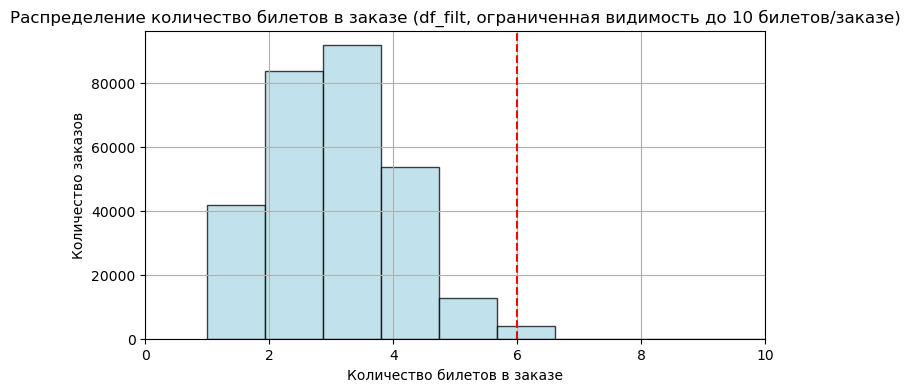

In [39]:
plt.figure(figsize=(8, 4))

df_filt['tickets_count'].plot(
                kind='hist', 
                bins= 60, 
                color='lightblue',
                alpha=0.75,
                edgecolor='black'
)

# Настраиваем оформление графика
plt.title('Распределение количество билетов в заказе (df_filt, ограниченная видимость до 10 билетов/заказе)')
plt.ylabel('Количество заказов')
plt.xlabel('Количество билетов в заказе')

plt.xlim(0, 10)  # Показываем только заказы до 10 билетов для видимости основной массы точек
plt.axvline(tickets_99, color='red', linestyle='--', 
           label=f'Граница выбросов: {tickets_99}')

plt.grid()

plt.show()

Для количества билетов 99 перцентиль = 6 билетов - вполне разумное значение

Выбросы (180 записей), максимум до 57. 

Решение: не фильтровать заказы по количеству билетов, т.к. во-первых, выбросов мало, во-вторых, такие заказы имеют информационную ценность (групповые/корпоративные)


### **Промежуточный вывод после предобработки данных:**

1. Выручка сервиса приведена к единой валюте — российскому рублю. Результаты преобразования сохранены в *новом столбце* `revenue_rub`.
2. *Пропуски* есть только в столбце `days_since_prev`: 21 933 пропуска или 7.55 %. Являются маркером *пользователей с одной покупкой*.
3. Уменьшена разрядность:
- для `order_id` и `event_id` к `int32`
- для `tickets_count` к `int8`

4. Количество дубликатов в данных до и после нормализации текстовых данных (приведение к нижнему регистру): 0

5. Удалены технические (неявные) дубликаты по `user_id` + `order_ts`: 170 строк (потеря данных: 0.058%)

6. Основная часть заказов имеет выручку `revenue_rub` до 2628 рублей (99 перцентиль).
   Пик распределения (50% данных): 114-802 рублей.
7. *Выбросы* (0.97% или 2825 заказов) в `revenue_rub` -  заказы от 2628 до 81 174 рублей - *отфильтрованы*, это новый датасет `df_filt`(287 786 строк)
 
8. Правосторонняя асимметрия распределения в `revenue_rub` сохраняется после фильтрации. На него влияют *381 отрицательное значение* (0.13% заказов, от 0 до -90.76 руб.), вероятно, *возвраты*.
Больше всего отрицательных заказов (возвратов) для типа мероприятий (event_type_main) "другое", 315 шт. и для билетного оператора (service_name) "билеты без проблем", 225 шт.

9. Распределение значений количества купленных билетов `tickets_count` близкое к нормальному (среднее 2.74, медиана 3.00),  99 перцентиль = 6 билетов.
*Выбросы* (180 заказов), максимум до 57 билетов - имеют информационную ценность (групповые/корпоративные), их мало.
Решено не фильтровать заказы по количеству билетов.


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [40]:
# Сортируем данные по времени совершения заказа
df_sort = df_filt.sort_values(by='order_ts')

In [ ]:
# Создание профиля пользователя 
user_profile = df_filt.sort_values(by='order_ts').groupby('user_id').agg(**{# агрегируем все нужные показатели за один проход
                    '1st_order_dt' : ('order_dt', 'min'),
                    'last_order_dt' : ('order_dt', 'max'),
                    # характеристики первого заказа: благодаря сортировке 'first' возьмет первую запись
                    '1st_order_device' : ('device_type_canonical', 'first'),
                    '1st_order_region' : ('region_name', 'first'),
                    '1st_order_service' : ('service_name', 'first'),
                    '1st_order_event_type' : ('event_type_main', 'first'),
                    'total_orders' : ('order_id', 'nunique'),  # уникальных заказов
                    'avg_revenue' : ('revenue_rub', 'mean'),   # средняя выручка
                    'avg_tickets' : ('tickets_count', 'mean'), # среднее количество билетов
                    'avg_days_between' : ('days_since_prev', 'mean') # среднее время между заказами
}).assign(# добавляем бинарные признаки (is_two, is_five): совершил ли пользователь 2 / 5 и более заказов 
                    is_two = lambda df: (df['total_orders'] >= 2).astype(int),   
                    is_five = lambda df: (df['total_orders'] >= 5).astype(int)
                ).reset_index() # сбрасываем индекс, чтобы user_id снова стал столбцом

# Проверяем результат
print(f"Создано профилей: {len(user_profile)}")
display(user_profile.head())

In [ ]:
user_profile.info()

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [44]:
# Считаем общее число пользователей в выборке, среднюю выручку с одного заказа, 
# долю пользователей, совершивших 2 и более заказа, долю пользователей, совершивших 5 и более заказов.

total_users = user_profile['user_id'].count()
print(f'Общее число пользователей в выборке: {total_users}')

avg_revenue_per_order = user_profile['avg_revenue'].mean().round(3)
print(f'Средняя выручка с одного заказа: {avg_revenue_per_order} руб.')

is_two_fraction = user_profile['is_two'].mean().round(2)
print(f'Доля пользователей, совершивших 2 и более заказа: {is_two_fraction}')

is_five_fraction = user_profile['is_five'].mean().round(2)
print(f'Доля пользователей, совершивших 5 и более заказов: {is_five_fraction}')

Общее число пользователей в выборке: 21854
Средняя выручка с одного заказа: 544.398 руб.
Доля пользователей, совершивших 2 и более заказа: 0.62
Доля пользователей, совершивших 5 и более заказов: 0.29


In [45]:
# Проверяем распределение данных по значениям в столбцах с бинарными признаками 
for column in ['is_two','is_five']:
    print(f'Распределение данных по значениям столбца {column}:')
    print(user_profile[column].value_counts(normalize=True))
    print()

Распределение данных по значениям столбца is_two:
is_two
1    0.617095
0    0.382905
Name: proportion, dtype: float64

Распределение данных по значениям столбца is_five:
is_five
0    0.709939
1    0.290061
Name: proportion, dtype: float64



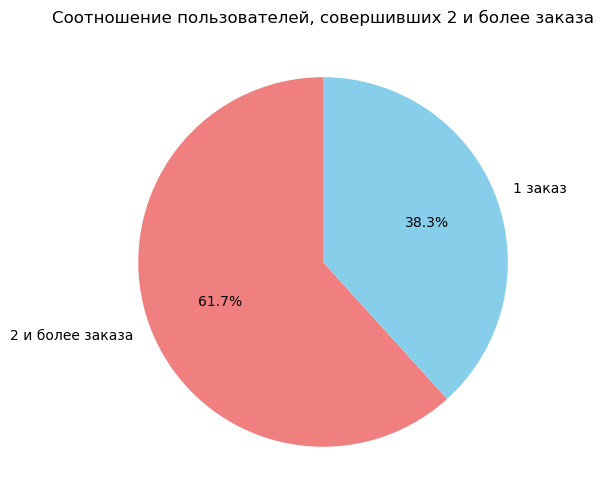

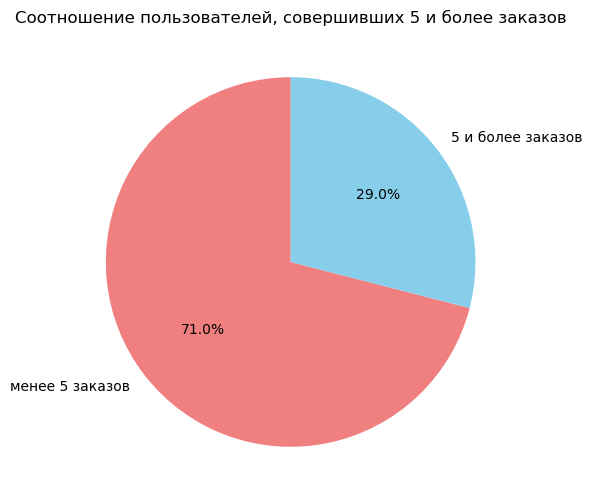

In [46]:
# Строим круговую диаграмму для пользователей сделавших 2 и более заказов, и 5 и более заказов
fig_1 = user_profile['is_two'].value_counts(normalize=True).plot(kind='pie',
    title='Соотношение пользователей, совершивших 2 и более заказа',
    colors=['lightcoral', 'skyblue'],
    autopct='%1.1f%%',  # Добавляем проценты на диаграмме
    startangle=90,      # Начинаем с верха
    figsize=(10, 6),
    labels=['2 и более заказа', '1 заказ']  
)

plt.ylabel('')  # Убираем label по оси Y 
plt.show()

fig_2 = user_profile['is_five'].value_counts(normalize=True).plot(kind='pie',
    title='Соотношение пользователей, совершивших 5 и более заказов',
    colors=['lightcoral', 'skyblue'],
    autopct='%1.1f%%',  # Добавляем проценты на диаграмме
    startangle=90,      # Начинаем с верха
    figsize=(10, 6),
    labels=['менее 5 заказов', '5 и более заказов'] 
)

plt.ylabel('')  # Убираем label по оси Y 
plt.show()

In [47]:
# Статистика для общего числа заказов
user_profile['total_orders'].describe()

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: total_orders, dtype: float64

In [48]:
# Проверяем выбросы в total_orders также по 95 и 99 перцентилю
total_orders_99 = user_profile['total_orders'].quantile(0.99)
print(f"99 перцентиль total_orders: {total_orders_99}")
total_orders_99_outliers = user_profile[user_profile['total_orders'] > total_orders_99]
print(f"Выбросов в total_orders(99 перцентиль): {len(total_orders_99_outliers)}")

total_orders_95 = user_profile['total_orders'].quantile(0.95)
print(f"\n95 перцентиль total_orders: {total_orders_95}")
total_orders_95_outliers = user_profile[user_profile['total_orders'] > total_orders_95]
print(f"Выбросов в total_orders(95 перцентиль): {len(total_orders_95_outliers)}")

99 перцентиль total_orders: 152.0
Выбросов в total_orders(99 перцентиль): 216

95 перцентиль total_orders: 31.349999999998545
Выбросов в total_orders(95 перцентиль): 1093


Выбросы в количестве заказов отфильтруем по 99 перцентилю, т.к. в этом случае отбросим лишь 1% данных

In [49]:
user_profile_filt = user_profile[user_profile['total_orders'] <= total_orders_99]
print("Статистика датасета user_profile до и после фильтрации выбросов в total_orders:")

print(f"  - Исходный датасет: {len(user_profile)} строк")
print(f"  - После фильтрации: {len(user_profile_filt)} строк")
print(f"  - 99-й перцентиль: {total_orders_99:.2f}")

Статистика датасета user_profile до и после фильтрации выбросов в total_orders:
  - Исходный датасет: 21854 строк
  - После фильтрации: 21638 строк
  - 99-й перцентиль: 152.00


In [50]:
# Статистика для среднего числа билетов в заказе
user_profile_filt['avg_tickets'].describe()

count    21638.000000
mean         2.743319
std          0.917486
min          1.000000
25%          2.000000
50%          2.750000
75%          3.095238
max         11.000000
Name: avg_tickets, dtype: float64

Среднее количество билетов в заказе близко к медиане, распределение близко к нормальному. Все данные оставляем.

In [51]:
# Статистика для среднего количества дней между покупками
user_profile_filt['avg_days_between'].describe()

count    13303.000000
mean        16.089190
std         22.389550
min          0.000000
25%          1.333333
50%          8.333333
75%         20.775000
max        148.000000
Name: avg_days_between, dtype: float64

In [52]:
# Проверяем выбросы в avg_days_between также по 95 и 99 перцентилю
avg_days_between_99 = user_profile_filt['avg_days_between'].quantile(0.99)
print(f"99 перцентиль avg_days_between: {avg_days_between_99} дней")
avg_days_between_99_outliers = user_profile_filt[user_profile_filt['avg_days_between'] > avg_days_between_99]
print(f"Выбросов в avg_days_between(99 перцентиль): {len(avg_days_between_99_outliers)}")

avg_days_between_95 = user_profile_filt['avg_days_between'].quantile(0.95)
print(f"\n95 перцентиль avg_days_between: {avg_days_between_95} дней")
avg_days_between_95_outliers = user_profile_filt[user_profile_filt['avg_days_between'] > avg_days_between_95]
print(f"Выбросов в avg_days_between(95 перцентиль): {len(avg_days_between_95_outliers)}")

99 перцентиль avg_days_between: 112.97999999999956 дней
Выбросов в avg_days_between(99 перцентиль): 134

95 перцентиль avg_days_between: 62.0 дней
Выбросов в avg_days_between(95 перцентиль): 655


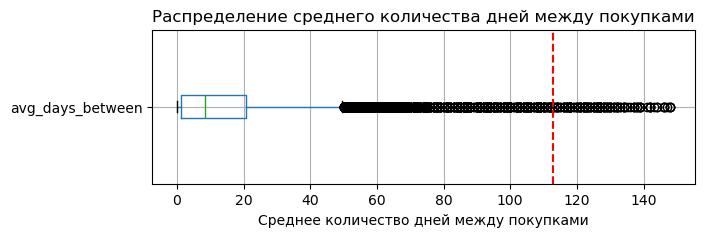

In [53]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце avg_days_between
user_profile_filt.boxplot(column='avg_days_between', vert=False)

plt.axvline(avg_days_between_99, color='red', linestyle='--', 
           label=f'Граница выбросов, 99 перцентиль: {avg_days_between_99}')

# Добавляем заголовок и метки оси
plt.title('Распределение среднего количества дней между покупками')
plt.xlabel('Среднее количество дней между покупками')

# Выводим график
plt.show()

Возможные интерпретации пользователей с большим промежутком между покупками: 

1. Сезонные покупатели (раз в 2-3 месяца)
2. Пользователи с высокой лояльностью, но низкой частотой
3. Корпоративные клиенты с редкими крупными заказами

Все данные для `avg_days_between` оставляем, т.к. эти выбросы необходимо учитывать при анализе.


### Промежуточный вывод:

- Общее число пользователей в выборке: 21 854
- Средняя выручка с одного заказа: 544.398 руб.
- Доля пользователей, совершивших 2 и более заказа: 0.62
- Доля пользователей, совершивших 5 и более заказов: 0.29

2. Аномальные значения обнаружены в столбце с общим числом заказов `total_orders`, они *отфильтрованы* по 99 перцентилю (=152 заказа):

    - отброшено 216 пользователей (1% данных)
    - исходный датасет: 21 854 строк, после фильтрации: 21 638 строк

Выбросы - это, вероятно, боты/тестовые аккаунты, корпоративные клиенты или аномалии в данных. *Если бы цель анализа была не типичный пользователь*, а *VIP-клиенты*, то их бы оставили и *анализировали отдельно*. 
      
3. Аномальные значения обнаружены в столбце со средним количеством дней между покупками `avg_days_between`:

   - 99 перцентиль: 113 дней, выбросов: 132
   - 95 перцентиль: 62 дня, выбросов: 655

Все данные для `avg_days_between` *оставляем*, т.к. эти выбросы могут отражать реальное поведение (*сезонность*).

4. Среднее количество билетов в заказе близко к медиане, распределение близко к нормальному. Все данные *оставляем*.
   
5. Профили пользователей готовы в новом датасете `user_profile_filt`.



---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---

In [54]:
# Напишем функцию для анализа распределения пользователей по категориям с долями и топ-категориями
def analyze_distribution(df, column, top_n=None):
    
# Количество пользователе в сегменте и их доля
    distribution = df[column].value_counts()
    proportion = df[column].value_counts(normalize=True)
    
# Датасет с результатами
    result = pd.DataFrame({
        'count': distribution,
        'proportion': proportion
    }).sort_values('count', ascending=False)
    
# Добавляем кумулятивную долю
    result['cumulative_proportion'] = result['proportion'].cumsum().round(2)
    
    if top_n:
        result = result.head(top_n)
    
    return result


In [55]:
# Тип мероприятия
print("Распределение пользователей по типу их первого мероприятия:")
event_dist = analyze_distribution(user_profile_filt, '1st_order_event_type')
print(event_dist)

# Тип устройства
print("\nРаспределение пользователей по типу устройства, с которого совершена первая покупка:")
device_dist = analyze_distribution(user_profile_filt, '1st_order_device')
print(device_dist)

# Регион (топ-10)
print("\nРаспределение пользователей по региону проведения мероприятия из первого заказа (топ-10):")
region_dist = analyze_distribution(user_profile_filt, '1st_order_region', top_n=10)
print(region_dist)

# Билетный оператор (топ-10)
print("\n Распределение пользователей по билетному оператору, продавшему билеты на первый заказ (топ-10):")
service_dist = analyze_distribution(user_profile_filt, '1st_order_service', top_n=10)
print(service_dist)

Распределение пользователей по типу их первого мероприятия:
                      count  proportion  cumulative_proportion
1st_order_event_type                                          
концерты               9560    0.441815                   0.44
другое                 5426    0.250763                   0.69
театр                  4239    0.195905                   0.89
стендап                1110    0.051299                   0.94
спорт                   794    0.036695                   0.98
выставки                414    0.019133                   1.00
ёлки                     95    0.004390                   1.00

Распределение пользователей по типу устройства, с которого совершена первая покупка:
                  count  proportion  cumulative_proportion
1st_order_device                                          
mobile            17924    0.828358                   0.83
desktop            3714    0.171642                   1.00

Распределение пользователей по региону проведения 

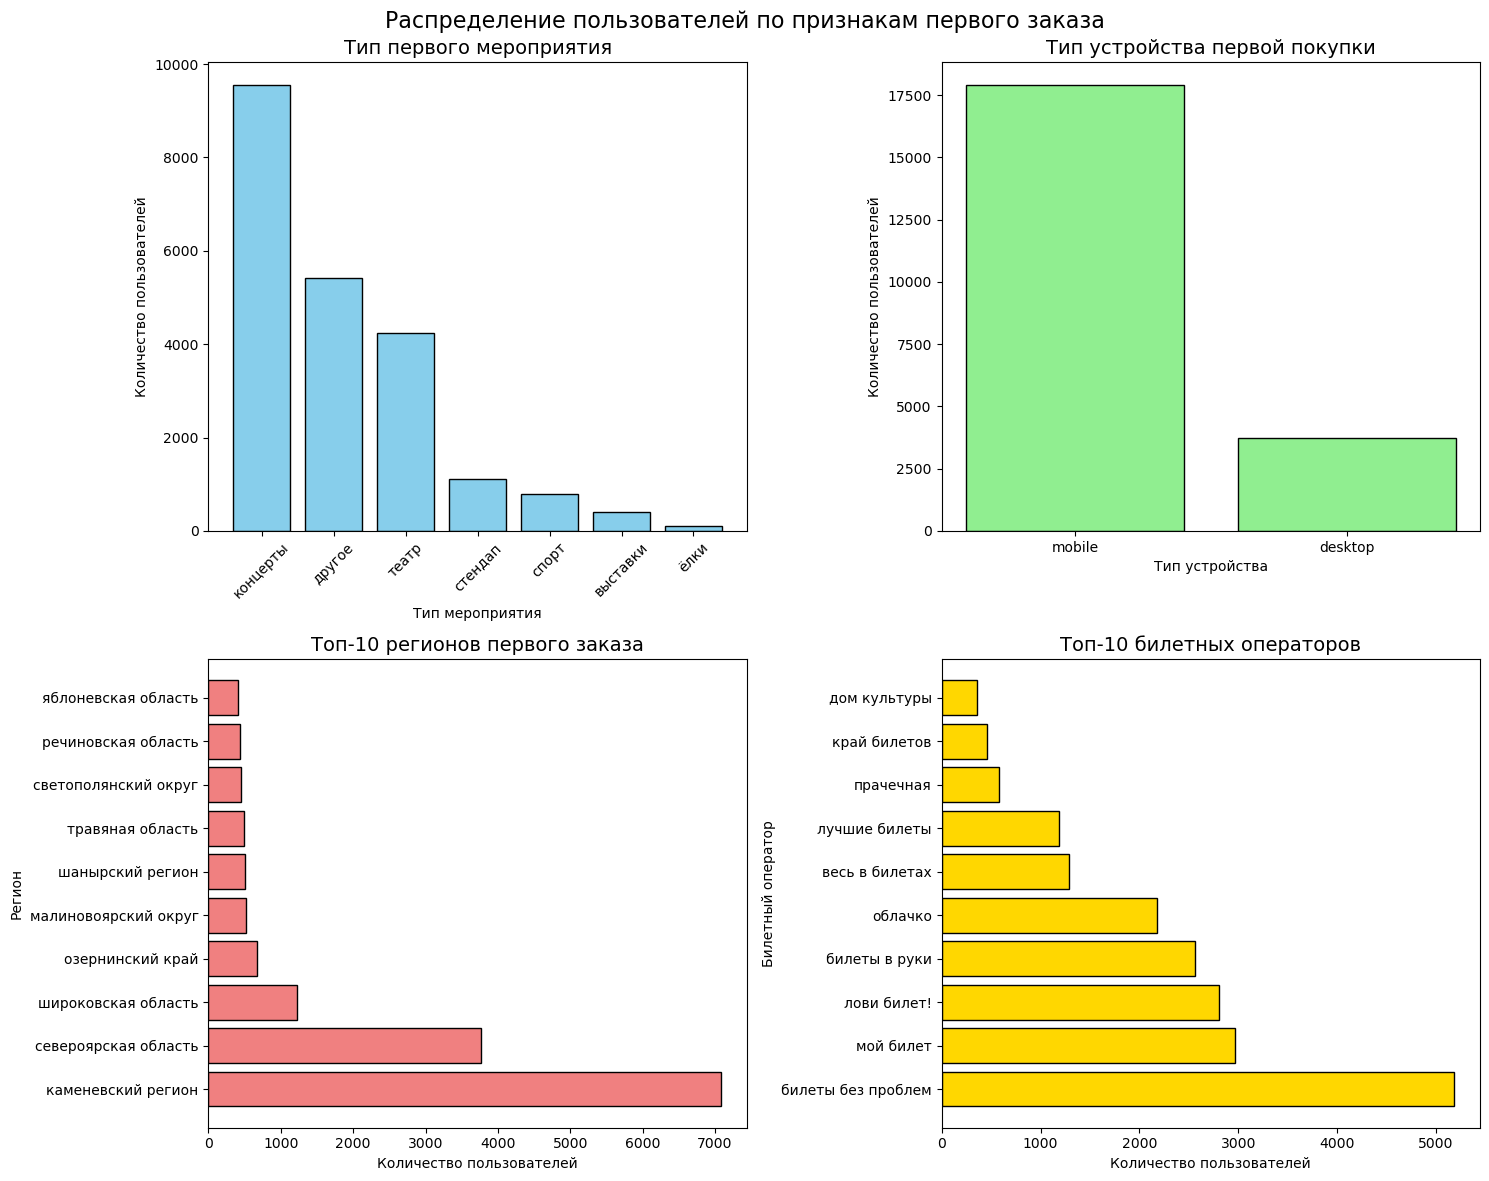

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Распределение пользователей по признакам первого заказа', fontsize=16)

# Тип мероприятия
event_order = event_dist.index
axes[0, 0].bar(event_order, event_dist['count'], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Тип первого мероприятия', fontsize=14)
axes[0, 0].set_xlabel('Тип мероприятия')
axes[0, 0].set_ylabel('Количество пользователей')
axes[0, 0].tick_params(axis='x', rotation=45)

# Тип устройства
axes[0, 1].bar(device_dist.index, device_dist['count'], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Тип устройства первой покупки', fontsize=14)
axes[0, 1].set_xlabel('Тип устройства')
axes[0, 1].set_ylabel('Количество пользователей')

# Регион (топ-10)
top_regions = region_dist.head(10)
axes[1, 0].barh(top_regions.index, top_regions['count'], color='lightcoral', edgecolor='black') 
axes[1, 0].set_title('Топ-10 регионов первого заказа', fontsize=14)
axes[1, 0].set_xlabel('Количество пользователей')
axes[1, 0].set_ylabel('Регион')

# Билетный оператор (топ-10)
top_services = service_dist.head(10)
axes[1, 1].barh(top_services.index, top_services['count'], color='gold', edgecolor='black')
axes[1, 1].set_title('Топ-10 билетных операторов', fontsize=14)
axes[1, 1].set_xlabel('Количество пользователей')
axes[1, 1].set_ylabel('Билетный оператор')

plt.tight_layout()
plt.show()

### Выводы:

1. Распределение пользователей по сегментам *неравномерное*.
   
2. "Точки входа" — сегменты с наибольшим числом пользователей:

По типу первого мероприятия:

       - Концерты 44.2%
       - Другое 25.1%
       - Театр 19.6%
*Топ-3* категории охватывают *89%* всех пользователей

По типу устройства:

        - mobile 82.8% 
        - desktop 17.2%
*Mobile доминирует* в качестве устройства, с которого совершена первая покупка


По региону первого заказа:

        - каменевский регион 32.7%
        - североярская область 17.4%
        - широковская область 5.6%    
*Топ-10 регионов* охватывают 72% всех пользователей


По билетному оператору первого заказа:

        - билеты без проблем 24%
        - мой билет 13.7%
        - лови билет! 13% 
*Топ-5 билетных операторов* охватывают 73% всех пользователей 

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---

In [57]:
# Для каждого сегмента из задачи выше считаем долю пользователей с 2+ заказами

# Тип мероприятия
event_retention = user_profile_filt.groupby('1st_order_event_type').agg({
    'user_id': 'count', 'is_two': 'mean'
}).rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'})

# Тип устройства  
device_retention = user_profile_filt.groupby('1st_order_device').agg({
    'user_id': 'count', 'is_two': 'mean'
}).rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'})

# Регион (топ-10)
top_regions = user_profile_filt['1st_order_region'].value_counts().head(10).index
region_retention = user_profile_filt[user_profile_filt['1st_order_region'].isin(top_regions)].groupby('1st_order_region').agg({
    'user_id': 'count', 'is_two': 'mean'
}).rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'})

# Билетный оператор (топ-10)
top_services = user_profile_filt['1st_order_service'].value_counts().head(10).index
service_retention = user_profile_filt[user_profile_filt['1st_order_service'].isin(top_services)].groupby('1st_order_service').agg({
    'user_id': 'count', 'is_two': 'mean'
}).rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'})

In [58]:
def display_table(df, title):
    print(f"\n{title}")
    
    # Форматируем датафрейм
    formatted_df = df.copy()
    formatted_df['total_users'] = formatted_df['total_users']
    formatted_df['retention_rate'] = formatted_df['retention_rate'].apply(lambda x: f"{x*100:.1f}%")
    
    formatted_df = formatted_df.sort_values('retention_rate', ascending=False)
    
    print(formatted_df.to_string())
    print()

display_table(event_retention, "Тип мероприятия")
display_table(device_retention, "Тип устройства")
display_table(region_retention, "Регионы (топ-10)")
display_table(service_retention, "Билетные операторы (топ-10)")


Тип мероприятия
                      total_users retention_rate
1st_order_event_type                            
выставки                      414          64.0%
театр                        4239          63.4%
концерты                     9560          61.8%
стендап                      1110          60.9%
другое                       5426          59.6%
спорт                         794          55.8%
ёлки                           95          55.8%


Тип устройства
                  total_users retention_rate
1st_order_device                            
desktop                  3714          63.8%
mobile                  17924          60.8%


Регионы (топ-10)
                      total_users retention_rate
1st_order_region                                
шанырский регион              500          67.2%
светополянский округ          457          65.6%
широковская область          1224          64.5%
североярская область         3767          63.8%
речиновская область           44

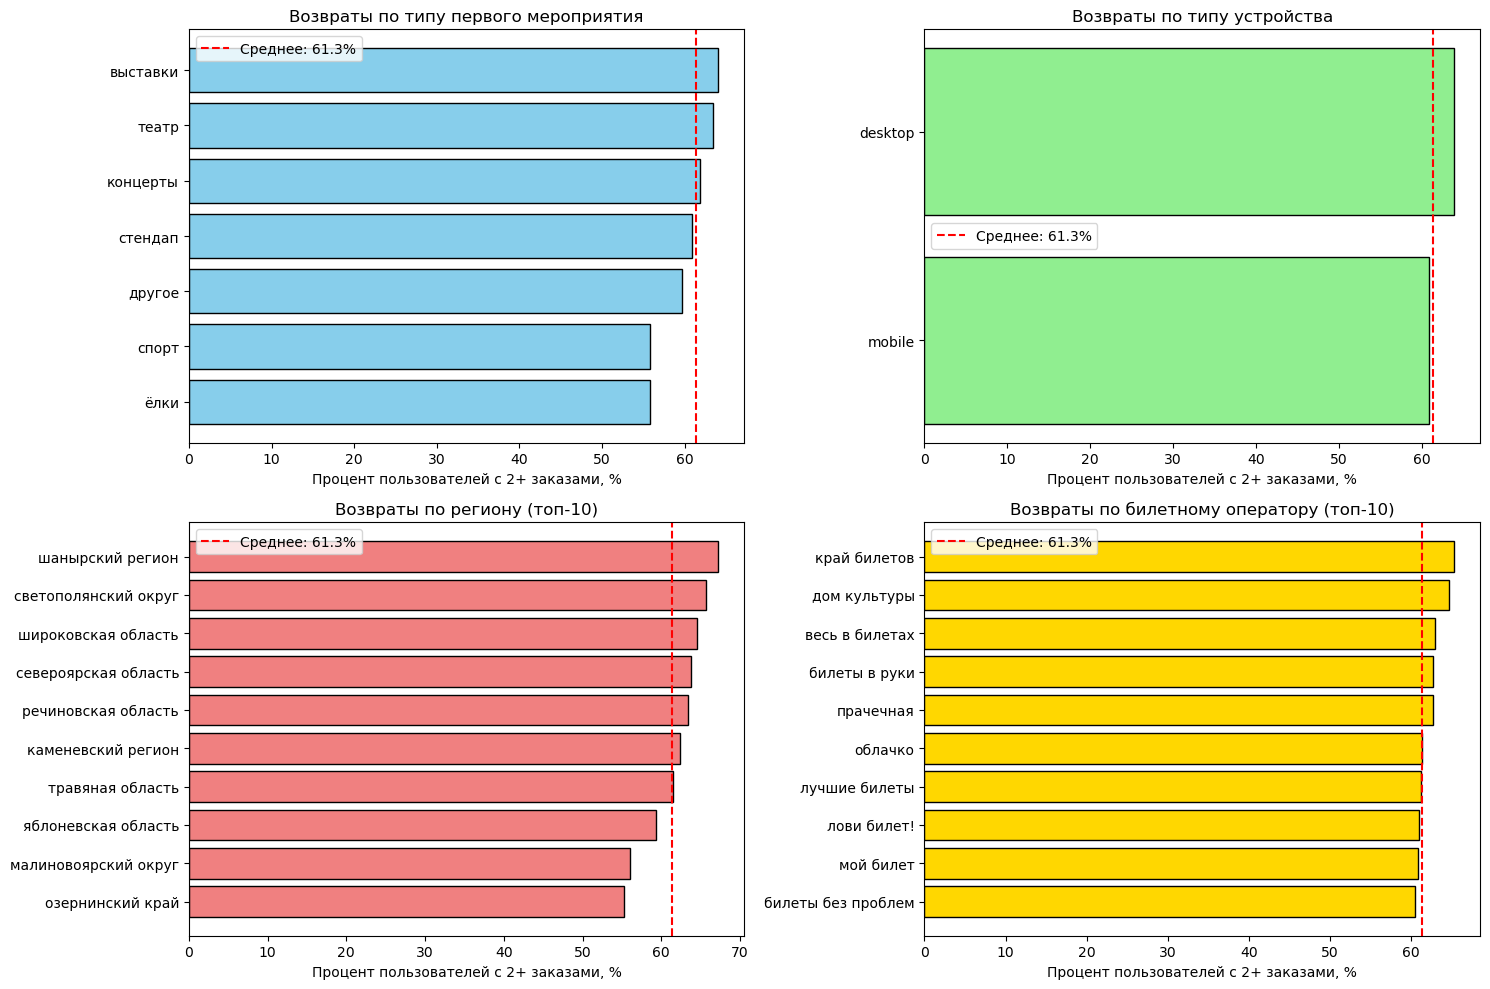

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Тип мероприятия
event_retention_sorted = event_retention.sort_values('retention_rate', ascending=True)
axes[0, 0].barh(range(len(event_retention_sorted)), event_retention_sorted['retention_rate'] * 100, color='skyblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(event_retention_sorted)))
axes[0, 0].set_yticklabels(event_retention_sorted.index)
axes[0, 0].set_xlabel('Процент пользователей с 2+ заказами, %')
axes[0, 0].set_title('Возвраты по типу первого мероприятия')

# Добавляем среднее по всей выборке
avg_retention = user_profile_filt['is_two'].mean()*100
axes[0, 0].axvline(avg_retention, color='red', linestyle='--', 
                  label=f'Среднее: {avg_retention:.1f}%')
axes[0, 0].legend()

# Тип устройства
device_retention_sorted = device_retention.sort_values('retention_rate', ascending=True)
axes[0, 1].barh(range(len(device_retention_sorted)), device_retention_sorted['retention_rate'] * 100, color='lightgreen', edgecolor='black')
axes[0, 1].set_yticks(range(len(device_retention_sorted)))
axes[0, 1].set_yticklabels(device_retention_sorted.index)
axes[0, 1].set_xlabel('Процент пользователей с 2+ заказами, %')
axes[0, 1].set_title('Возвраты по типу устройства')
axes[0, 1].axvline(avg_retention, color='red', linestyle='--', 
                   label=f'Среднее: {avg_retention:.1f}%')
axes[0, 1].legend()

# Регион (топ-10)
region_retention_sorted = region_retention.sort_values('retention_rate', ascending=True)
axes[1, 0].barh(range(len(region_retention_sorted)), region_retention_sorted['retention_rate'] * 100, color='lightcoral', edgecolor='black')
axes[1, 0].set_yticks(range(len(region_retention_sorted)))
axes[1, 0].set_yticklabels([label[:20] + '...' if len(label) > 20 else label 
                           for label in region_retention_sorted.index])
axes[1, 0].set_xlabel('Процент пользователей с 2+ заказами, %')
axes[1, 0].set_title('Возвраты по региону (топ-10)')
axes[1, 0].axvline(avg_retention, color='red', linestyle='--', 
                   label=f'Среднее: {avg_retention:.1f}%')
axes[1, 0].legend()

# Билетный оператор (топ-10)
service_retention_sorted = service_retention.sort_values('retention_rate', ascending=True)
axes[1, 1].barh(range(len(service_retention_sorted)), service_retention_sorted['retention_rate'] * 100, color='gold', edgecolor='black')
axes[1, 1].set_yticks(range(len(service_retention_sorted)))
axes[1, 1].set_yticklabels([label[:20] + '...' if len(label) > 20 else label 
                           for label in service_retention_sorted.index])
axes[1, 1].set_xlabel('Процент пользователей с 2+ заказами, %')
axes[1, 1].set_title('Возвраты по билетному оператору (топ-10)')
axes[1, 1].axvline(avg_retention, color='red', linestyle='--', 
                   label=f'Среднее: {avg_retention:.1f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Ответы на вопросы:
**1. Сегменты пользователей чаще возвращаются на Яндекс Афишу (сегменты выше среднего по выборке), если их первый заказ был:**
   
- *По типу первого мероприятия*:

    Выставки — самый высокий возврат (64%), но небольшой сегмент (414 пользователей)

    Театр — высокий возврат при значительном объеме сегмента (4239 пользователей)

    Концерты — высокий возврат при самом большом объеме сегмента (9560 пользователей)

  
- *По типу устройства*:

    Desktop — высокий возврат 64% (3714 пользователей)


- *По региону*:

    Шанырский регион — самый высокий возврат (67%) (500 пользователей в сегменте)

    Светополянский округ — высокий возврат (457 пользователей)

    Широковская область — высокий возврат (1224 пользователей, входит в топ-3 по региону первого заказа)

    Североярская область  — высокий возврат (3767 пользователей, входит в топ-3 по региону первого заказа)

    Каменевский регион - высокий возврат (7085 пользователей, входит в топ-3 по региону первого заказа)      


- *По билетному оператору*:

    Край билетов — самый высокий возврат (454 пользователей в сегменте)

    Дом культуры — высокий возврат (356 пользователей)

    Весь в билетах — высокий возврат (1285 пользователей)

    Билеты в руки — высокий возврат (2559 пользователей)          


**2. Можно выделить две категории "точек входа" по объему сегментов:**

- *Крупные (> 1000 пользователей) и успешные (возврат выше среднего):*
    1. Desktop-пользователи
    2. Театралы
    3. Посетители концертов
    4. Посетители из Широковской области, Североярской области, Каменевского региона
    5. Посетители сделавшие первый заказ у операторов "Весь в билетах" и "Билеты в руки"


- *Менее объемные (результаты могут быть нестабильными), но перспективные (возврат выше среднего):*
    1. Выставки (414 пользователей)
    2. Шанырский регион (500 пользователей) и Светополянский округ (457 пользователей)
    3. "Край билетов" (454 пользователей)



---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [60]:
# Проверка Гипотезы 1 
sport_data = event_retention.loc['спорт']
concert_data = event_retention.loc['концерты']

print(f"Концерты: пользователей с 2+ заказами {concert_data['retention_rate']*100:.1f}% (величина сегмента {concert_data['total_users']} чел.)")
print(f"Спорт: пользователей с 2+ заказами {sport_data['retention_rate']*100:.1f}% (величина сегмента {sport_data['total_users']} чел.)")

Концерты: пользователей с 2+ заказами 61.8% (величина сегмента 9560.0 чел.)
Спорт: пользователей с 2+ заказами 55.8% (величина сегмента 794.0 чел.)


In [61]:
print(f"Пользователи, которые совершили свой первый заказ на концерты имеют возврат на {concert_data['retention_rate']*100 - sport_data['retention_rate']*100:.1f} пп выше")

Пользователи, которые совершили свой первый заказ на концерты имеют возврат на 6.0 пп выше


Гипотеза 1 не подтверждена.

In [62]:
# Проверка Гипотезы 2. Создадим функцию для анализа возвратов по регионам

def analyze_retention(df, region_col, retention_col, top_n=10):
   
    # Топ регионы по количеству пользователей, получаем их список
    top_regions = df[region_col].value_counts().head(top_n).index
    
    # Создаем маску для топ-регионов и считаем в них возвраты и количество пользователей
    top_mask = df[region_col].isin(top_regions)
    top_retention = df.loc[top_mask, retention_col].mean()
    top_count = top_mask.sum()
    
    # Возвраты и количество пользователей в остальных регионах
    other_retention = df.loc[~top_mask, retention_col].mean()
    other_count = (~top_mask).sum()
    
    return {
        'top_regions': top_regions.tolist(),
        'top_retention': top_retention,
        'top_count': top_count,
        'other_retention': other_retention,
        'other_count': other_count,
        'difference': top_retention - other_retention
    }

result = analyze_retention(user_profile_filt, '1st_order_region', 'is_two')

print(f"Топ-10 регионов: {result['top_count']} пользователей")
print(f"Возврат в топ-регионах: {result['top_retention']*100:.2f}%")
print(f"\nОстальные регионы: {result['other_count']} пользователей")
print(f"Возврат в остальных регионах: {result['other_retention']*100:.2f}%")

Топ-10 регионов: 15572 пользователей
Возврат в топ-регионах: 62.55%

Остальные регионы: 6066 пользователей
Возврат в остальных регионах: 58.18%


In [63]:
print(f"В топ-10 регионов, где больше всего пользователей посещают мероприятия, повторных заказов на {result['difference']*100:.1f} пп больше, чем в менее активных регионах")

В топ-10 регионов, где больше всего пользователей посещают мероприятия, повторных заказов на 4.4 пп больше, чем в менее активных регионах


Гипотеза 2 подтверждена.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


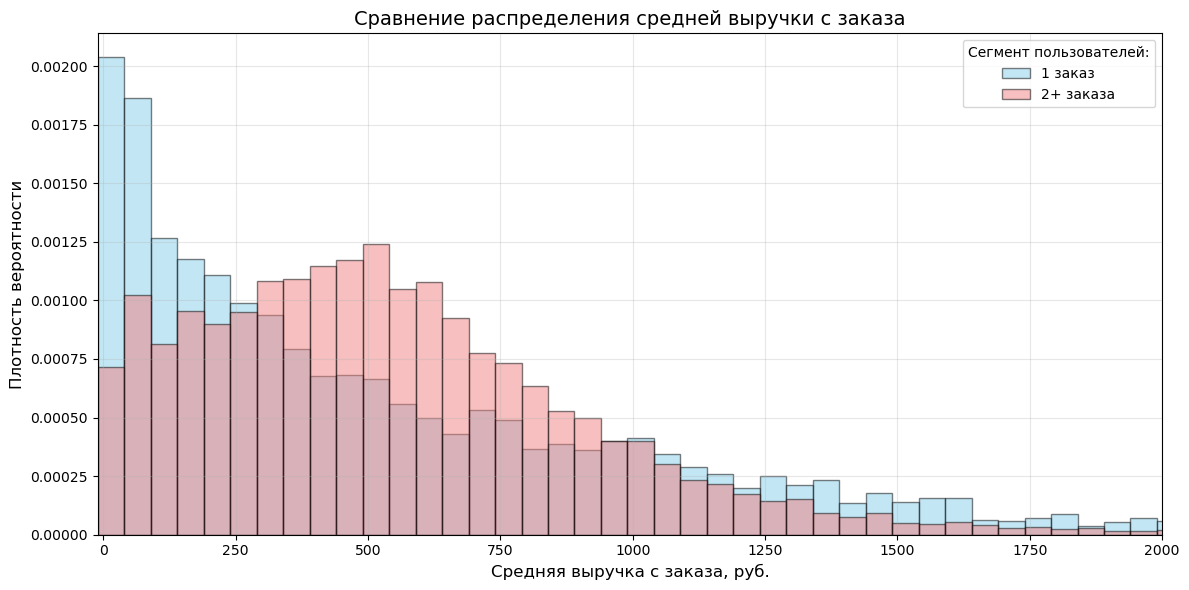

In [64]:
# Строим гистограмму распределения средней выручки с одного заказа

# Создаём фигуру графика
plt.figure(figsize=(12, 6))

# Находим минимальное и максимальное значения, чтобы скорректировать размер bins
min_value = int(user_profile_filt['avg_revenue'].min())
max_value = int(user_profile_filt['avg_revenue'].max())
step = 50
bins_range = list(range(min_value, max_value + step, step))

# Создаем список цветов и легенду
colors = ['skyblue', 'lightcoral']
labels = {0: '1 заказ', 1: '2+ заказа'}

# Строим гистограммы для каждого значения is_two
for i in user_profile_filt['is_two'].unique():
    # Фильтруем данные по значению столбца is_two
    user_profile_filt.loc[user_profile_filt['is_two'] == i, 'avg_revenue'].plot(
        kind='hist',
        density=True,
        bins=bins_range,
        alpha=0.5,
        edgecolor='black',
        color=colors[i],
        label=labels[i],
        legend=True
    )
 
# Настраиваем внешний вид графика и выводим его на экран
plt.title('Сравнение распределения средней выручки с заказа', fontsize=14)
plt.xlabel('Средняя выручка с заказа, руб.', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(title='Сегмент пользователей:')
plt.grid(True, alpha=0.3)
plt.xlim(-10, 2000)  # Ограничиваем для лучшей видимости
plt.tight_layout()
plt.show()




In [65]:
# Разделяем пользователей на две группы и выводим статистику
single_buyers = user_profile_filt[user_profile_filt['is_two'] == 0]  # 1 заказ
returning_buyers = user_profile_filt[user_profile_filt['is_two'] == 1]  # 2+ заказов

print(f"Статистика по средней выручке с заказа для пользователей с 1 заказом: \n{single_buyers['avg_revenue'].describe()}")

print(f"\nСтатистика по средней выручке с заказа для пользователей с 2+ заказами:\n{returning_buyers['avg_revenue'].describe()}")


Статистика по средней выручке с заказа для пользователей с 1 заказом: 
count    8368.000000
mean      545.295642
std       519.514097
min       -10.770000
25%       132.070000
50%       378.030000
75%       830.317500
max      2628.421739
Name: avg_revenue, dtype: float64

Статистика по средней выручке с заказа для пользователей с 2+ заказами:
count    13270.000000
mean       544.337170
std        369.354468
min         -5.385000
25%        270.814375
50%        495.772429
75%        745.165500
max       2628.421739
Name: avg_revenue, dtype: float64


### Ответы на вопросы:

1. *Диапазоны средней выручки:*
   - для пользователей, совершивших один заказ: 132 - 830 руб.
   - для вернувшихся пользователей, совершивших 2 и более заказа: 271 - 745 руб.


2. *Различия между группами*:
   - для вернувшихся пользователей выручка в среднем выше: 496 руб. против 378 руб. для пользователей с одним заказом.
   - распределение у вернувшихся пользователей уже (std 369 vs 519)


**Ключевой вывод:**
Вернувшиеся пользователи имеют более стабильную и предсказуемую выручку (меньший разброс), а их типичный заказ (медиана) дороже. 



---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [66]:
 user_profile_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21638 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               21638 non-null  object        
 1   1st_order_dt          21638 non-null  datetime64[ns]
 2   last_order_dt         21638 non-null  datetime64[ns]
 3   1st_order_device      21638 non-null  object        
 4   1st_order_region      21638 non-null  object        
 5   1st_order_service     21638 non-null  object        
 6   1st_order_event_type  21638 non-null  object        
 7   total_orders          21638 non-null  int64         
 8   avg_revenue           21638 non-null  float64       
 9   avg_tickets           21638 non-null  float64       
 10  avg_days_between      13303 non-null  float64       
 11  is_two                21638 non-null  int64         
 12  is_five               21638 non-null  int64         
dtypes: datetime64[ns](2),

In [67]:
# Создаем копию датафрейма для безопасности и оставляем данные только для пользователей с 2+ заказами
user_profile_task = user_profile_filt.copy()
user_profile_task = user_profile_task[user_profile_task['is_two'] == 1]
user_profile_task.head()

,user_id,1st_order_dt,last_order_dt,1st_order_device,1st_order_region,1st_order_service,1st_order_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between,is_two,is_five
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.000000,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.000000,1,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0
5,000cf0659a9f40f,2024-06-20 10:35:26,2024-06-21 04:36:17,mobile,широковская область,лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
6,00147c9209d45d3,2024-06-25 23:26:58,2024-06-25 23:28:52,mobile,каменевский регион,облачко,концерты,2,352.945000,1.500000,0.000000,1,0


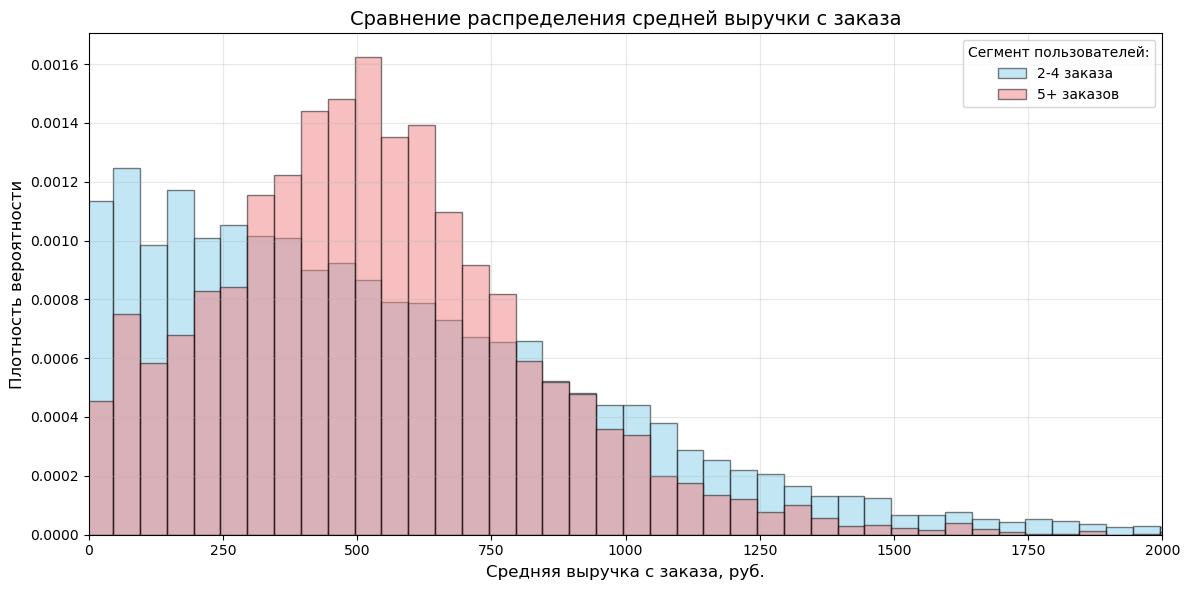

In [68]:
# Строим гистограмму распределения средней выручки с одного заказа

# Создаём фигуру графика
plt.figure(figsize=(12, 6))

# Находим минимальное и максимальное значения, чтобы скорректировать размер bins
min_value = int(user_profile_task['avg_revenue'].min())
max_value = int(user_profile_task['avg_revenue'].max())
step = 50
bins_range = list(range(min_value, max_value + step, step))

# Создаем список цветов и легенду
colors = ['skyblue', 'lightcoral']
labels = {0: '2-4 заказа', 1: '5+ заказов'}

# Строим гистограммы для каждого значения is_two
for i in user_profile_task['is_five'].unique():
    # Фильтруем данные по значению столбца is_two
    user_profile_task.loc[user_profile_task['is_five'] == i, 'avg_revenue'].plot(
        kind='hist',
        density=True,
        bins=bins_range,
        alpha=0.5,
        edgecolor='black',
        color=colors[i],
        label=labels[i],
        legend=True
    )
 
# Настраиваем внешний вид графика и выводим его на экран
plt.title('Сравнение распределения средней выручки с заказа', fontsize=14)
plt.xlabel('Средняя выручка с заказа, руб.', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(title='Сегмент пользователей:')
plt.grid(True, alpha=0.3)
plt.xlim(0, 2000)  # Ограничиваем для лучшей видимости
plt.tight_layout()
plt.show()


In [69]:
# Разделяем пользователей на две группы и выводим статистику
two_four_buyers = user_profile_task[user_profile_task['is_five'] == 0]  # 2-4 заказ
five_more_buyers = user_profile_task[user_profile_task['is_five'] == 1]  # 5+ заказов

print(f"Статистика по средней выручке с заказа для пользователей с 2-4 заказами: \n{two_four_buyers['avg_revenue'].describe()}")

print(f"\nСтатистика по средней выручке с заказа для пользователей с 5+ заказами:\n{five_more_buyers['avg_revenue'].describe()}")

Статистика по средней выручке с заказа для пользователей с 2-4 заказами: 
count    7147.000000
mean      551.572386
std       420.197691
min        -5.385000
25%       218.428750
50%       471.266667
75%       798.550000
max      2628.421739
Name: avg_revenue, dtype: float64

Статистика по средней выручке с заказа для пользователей с 5+ заказами:
count    6123.000000
mean      535.891950
std       299.089582
min         0.000000
25%       330.456122
50%       512.650613
75%       700.809038
max      2299.869022
Name: avg_revenue, dtype: float64


### Ответ на вопрос:

- Для пользователей с 5+ заказами значение средней выручки с заказа (медиана) оказалось выше, чем для сегмента с 2-4 заказами: 513 руб. vs 471 руб. Но эта разница невелика.

- Для пользователей с 5+ заказами данные имеют меньший разброс (299 руб), чем у сегмента с 2-4 заказами (420 руб), т.е. выручка с заказа более предсказуема.


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [70]:
print('Статистические показатели столбца avg_tickets в датасете с профилями пользователей:')
user_profile_filt['avg_tickets'].describe()

Статистические показатели столбца avg_tickets в датасете с профилями пользователей:


count    21638.000000
mean         2.743319
std          0.917486
min          1.000000
25%          2.000000
50%          2.750000
75%          3.095238
max         11.000000
Name: avg_tickets, dtype: float64

In [71]:
# Проверяем выбросы в avg_tickets по 99 перцентилю
avg_tickets_99 = user_profile_filt['avg_tickets'].quantile(0.99)
print(f"99 перцентиль avg_tickets: {avg_tickets_99}")
avg_tickets_outliers = user_profile_filt[user_profile_filt['avg_tickets'] > avg_tickets_99]
print(f"\nВыбросов в avg_tickets: {len(avg_tickets_outliers)}")

99 перцентиль avg_tickets: 5.0

Выбросов в avg_tickets: 194


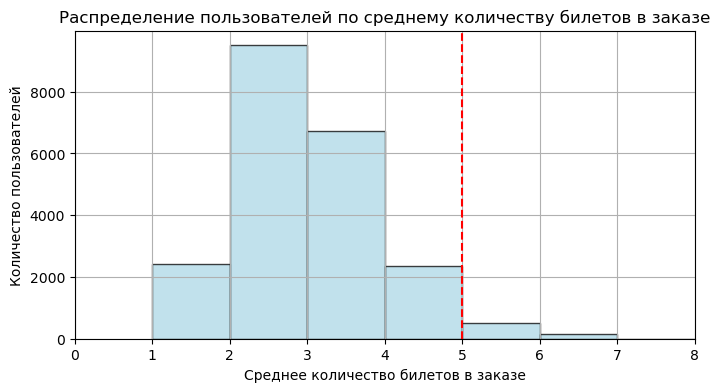

In [72]:
plt.figure(figsize=(8, 4))

user_profile_filt['avg_tickets'].plot(
                kind='hist', 
                bins= 10, 
                color='lightblue',
                alpha=0.75,
                edgecolor='black'
)

# Настраиваем оформление графика
plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.ylabel('Количество пользователей')
plt.xlabel('Среднее количество билетов в заказе')

plt.xlim(0, 8)  # Показываем только заказы до 8 билетов для видимости основной массы точек
plt.axvline(avg_tickets_99, color='red', linestyle='--', 
           label=f'99 перцентиль: {avg_tickets_99}')

plt.grid()

plt.show()

**Результаты:**

1. Распределение пользователей по среднему количеству билетов в заказе близко к нормальному: об этом говорит близость среднего (2.74) к медиане (2.75).
2. 99 перцентиль равен 5 билетам, макcимальное значение 11 билетов. (Выбросы 194 пользователя) могут относится к корпоративным заказам. 



In [73]:
# Разделяем пользователей на сегменты по среднему количеству билетов в заказе
user_profile_segments = user_profile_filt.copy()
user_profile_segments['avg_tickets_group'] = pd.cut(user_profile_segments['avg_tickets'],
                                               bins=[1, 2, 3, 5, 12],
                                               labels=['1-2 билета', '2-3 билета', '3-5 билетов', '5 и > билетов'],
                                               right=False)
print("Количество пользователей в сегменте:")
print(user_profile_segments['avg_tickets_group'].value_counts().sort_values(ascending=False))

Количество пользователей в сегменте:
avg_tickets_group
2-3 билета       9498
3-5 билетов      9060
1-2 билета       2419
5 и > билетов     661
Name: count, dtype: int64


In [74]:
segment_stats = user_profile_segments.groupby('avg_tickets_group', observed=True).agg({
    'user_id': 'count',
    'is_two': 'mean'
    ,'is_five': 'mean'
    ,'avg_tickets': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'is_two': 'retention_rate_2plus',
    'is_five': 'retention_rate_5plus',
    'avg_tickets': 'avg_tickets_in_segment'
})

# Добавляем процент от общего числа
segment_stats['total_users_%'] = (segment_stats['total_users'] / len(user_profile_segments) * 100).round()
#segment_stats['total_users_cumul_%'] = segment_stats['total_users_%'].cumsum()


display(segment_stats.sort_values(by='total_users', ascending=False))

,total_users,retention_rate_2plus,retention_rate_5plus,avg_tickets_in_segment,total_users_%
avg_tickets_group,,,,,
2-3 билета,9498,0.735839,0.412192,2.327562,44.0
3-5 билетов,9060,0.542605,0.204084,3.387256,42.0
1-2 билета,2419,0.513022,0.143034,1.267067,11.0
5 и > билетов,661,0.187595,0.019667,5.293762,3.0


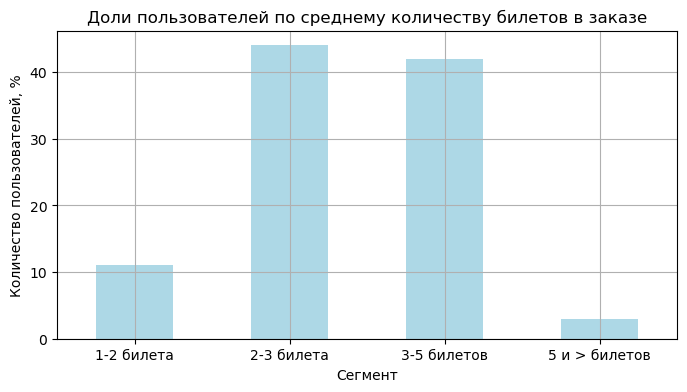

In [75]:
# Строим график столбчатой диаграммы для процента пользователей по сегментам
plt.figure(figsize=(8, 4))

segment_stats['total_users_%'].plot(kind='bar',
               title=f'Доли пользователей по среднему количеству билетов в заказе',
               legend=False,
               ylabel='Количество пользователей, %',
               xlabel='Сегмент',
               color='lightblue',
               rot=0
               )

plt.grid()

# Выводим график
plt.show()

### Ответы на вопросы:

1. Основная доля пользователей (86%) сконцентрирована в сегментах *"2-3 билета"* и *"3-5 билетов"*.
   
2. Для сегмента *"2-3 билета"*: порядка 74% пользователей вернулось, сделав 2+ заказов, а 41% пользователей - 5+ заказов.
   
3. Для сегмента *"5 и > билетов"*: доля повторных 5+ заказов аномально низкая, 2%, вероятно, обусловлена малой выборкой (661 пользователь).


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [76]:
user_profile_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21638 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               21638 non-null  object        
 1   1st_order_dt          21638 non-null  datetime64[ns]
 2   last_order_dt         21638 non-null  datetime64[ns]
 3   1st_order_device      21638 non-null  object        
 4   1st_order_region      21638 non-null  object        
 5   1st_order_service     21638 non-null  object        
 6   1st_order_event_type  21638 non-null  object        
 7   total_orders          21638 non-null  int64         
 8   avg_revenue           21638 non-null  float64       
 9   avg_tickets           21638 non-null  float64       
 10  avg_days_between      13303 non-null  float64       
 11  is_two                21638 non-null  int64         
 12  is_five               21638 non-null  int64         
dtypes: datetime64[ns](2),

In [77]:
user_profile_time = user_profile_filt.copy()
user_profile_time['1st_order_weekday'] = user_profile_time['1st_order_dt'].dt.day_name()  
#Проверим
user_profile_time.head()


,user_id,1st_order_dt,last_order_dt,1st_order_device,1st_order_region,1st_order_service,1st_order_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between,is_two,is_five,1st_order_weekday
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,Tuesday
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0,Tuesday
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0,Saturday
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,Thursday
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,Sunday


In [78]:
weekday_stats = (user_profile_time.groupby('1st_order_weekday', as_index=False).agg(
                     total_users=('user_id', 'count'),
                     returning_users_count=('is_two', 'sum'),  # Количество вернувшихся пользователей
                     returning_users=('is_two', 'mean')))  # Доля вернувшихся пользователей

# Зададим порядок дней недели для корректной сортировки и сортируем
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_stats['1st_order_weekday'] = pd.Categorical(weekday_stats['1st_order_weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('1st_order_weekday')


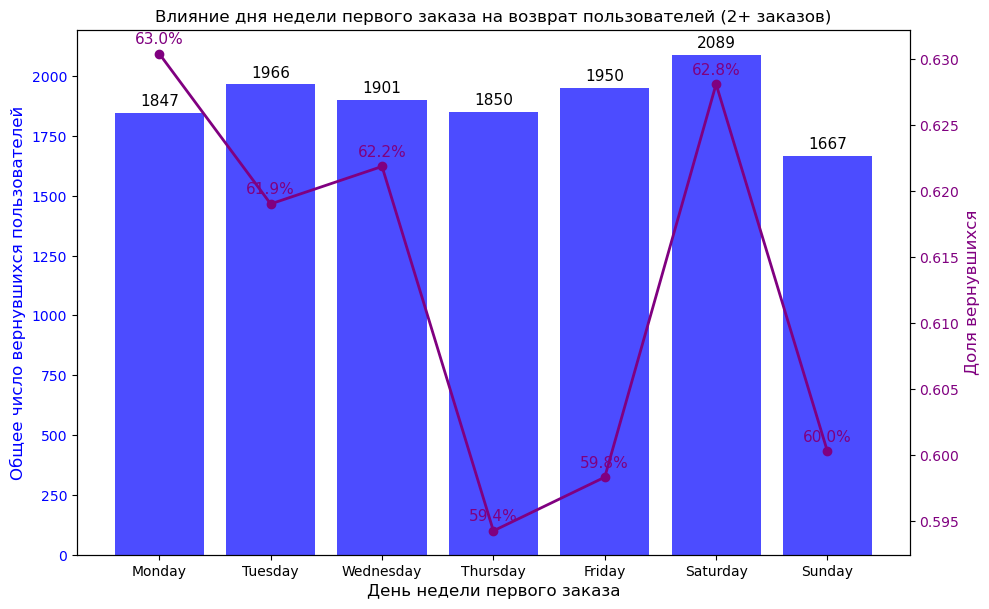

  1st_order_weekday  total_users  returning_users_count  returning_users
1            Monday         2930                   1847         0.630375
5           Tuesday         3176                   1966         0.619018
6         Wednesday         3057                   1901         0.621851
4          Thursday         3113                   1850         0.594282
0            Friday         3259                   1950         0.598343
2          Saturday         3326                   2089         0.628082
3            Sunday         2777                   1667         0.600288


In [79]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'blue'
ax1.set_xlabel('День недели первого заказа', fontsize=12)
ax1.set_ylabel('Общее число вернувшихся пользователей', color=color1, fontsize=12)
bars = ax1.bar(weekday_stats['1st_order_weekday'], weekday_stats['returning_users_count'], color=color1, alpha=0.7, label='Вернувшиеся пользователи')
ax1.tick_params(axis='y', labelcolor=color1)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Смещение по вертикали
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=11)

ax2 = ax1.twinx()  # Создаем вторую ось Y
color2 = 'purple'
ax2.set_ylabel('Доля вернувшихся', color=color2, fontsize=12)
line = ax2.plot(weekday_stats['1st_order_weekday'], weekday_stats['returning_users'],
                color=color2, marker='o', linewidth=2, label='Доля вернувшихся')
ax2.tick_params(axis='y', labelcolor=color2)

# Добавляем значения на линию
for x, y in zip(weekday_stats['1st_order_weekday'], weekday_stats['returning_users']):
    ax2.annotate(f'{y:.1%}', xy=(x, y), xytext=(0, 5), textcoords="offset points",
                 ha='center', va='bottom', fontsize=11, color=color2)

fig.tight_layout()
plt.title('Влияние дня недели первого заказа на возврат пользователей (2+ заказов)')
plt.show()

print(weekday_stats) #[['1st_order_weekday', 'returning_users_count', 'returning_users']])

### Ответ на вопрос:

Доля вернувшихся пользователей в зависимости от дня недели первого заказа находится в интервале 59,4 - 63%.
Т.е. день недели первой покупки слабо влияет на возврат пользователя.


---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


 В задаче 4.2.2 мы уже сделали датафрейм `user_profile_task` с данными только для пользователей с 2+ заказами и разделили пользователей на две группы: `two_four_buyers` (2-4 заказа) и `five_more_buyers` (5+ заказов)

In [80]:
print(f"Статистика по среднему времени между заказами для пользователей с 2-4 заказами: \n{two_four_buyers['avg_days_between'].describe()}")

print(f"\nСтатистика по среднему времени между заказами для пользователей с 5+ заказами:\n{five_more_buyers['avg_days_between'].describe()}")

Статистика по среднему времени между заказами для пользователей с 2-4 заказами: 
count    7147.000000
mean       21.317662
std        28.474747
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between, dtype: float64

Статистика по среднему времени между заказами для пользователей с 5+ заказами:
count    6123.000000
mean        9.903831
std         7.812950
min         0.000000
25%         3.880570
50%         8.125000
75%        14.125000
max        37.500000
Name: avg_days_between, dtype: float64


- Для пользователей с 2-4 заказами:
    - медианный интервал времени между заказами: 9 дней
    - средний интервал времени между заказами: 21 день
    - разница объясняется сильно скошенным распределением (std = 28)

  
- Для пользователей с 5+ заказами:
    - медианный интервал времени между заказами: 8 дней
    - средний интервал времени между заказами: 10 дней
    - распределение более симметричное (std = 8)
  



**Переформулируем второй пункт задачи:**
Нужно исследовать как `avg_days_between` (средний интервал) связан с `is_five` (вероятность стать постоянным клиентом).
Т.е. как частота покупок влияет на вероятность того, что пользователь станет постоянным клиентом.

**Гипотеза:** чем *меньше* интервал между заказами, тем *выше* вероятность, что пользователь станет постоянным клиентом.

In [81]:
user_profile_task.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13270 entries, 1 to 21851
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               13270 non-null  object        
 1   1st_order_dt          13270 non-null  datetime64[ns]
 2   last_order_dt         13270 non-null  datetime64[ns]
 3   1st_order_device      13270 non-null  object        
 4   1st_order_region      13270 non-null  object        
 5   1st_order_service     13270 non-null  object        
 6   1st_order_event_type  13270 non-null  object        
 7   total_orders          13270 non-null  int64         
 8   avg_revenue           13270 non-null  float64       
 9   avg_tickets           13270 non-null  float64       
 10  avg_days_between      13270 non-null  float64       
 11  is_two                13270 non-null  int64         
 12  is_five               13270 non-null  int64         
dtypes: datetime64[ns](2),

In [82]:
# Создаем категории интервалов 
user_profile_task['interval_cat'] = pd.cut(user_profile_task['avg_days_between'],
    bins=[0, 7, 14, 30, 90, 200],
    labels=['≤7 дней', '8-14 дней', '15-30 дней', '31-90 дней', '>90 дней']
)

# Анализируем сколько пользователей в каждой категории и какая в ней доля постоянных клиентов с 5+ заказами
interval_summary = user_profile_task.groupby('interval_cat', observed=True).agg(
    users=('user_id', 'count'),
    const_buyers_share=('is_five', 'mean')
).reset_index()


# Влияние среднего времени между заказами на вероятность стать постоянным клиентом с 5+ заказами
for _, row in interval_summary.iterrows():
    print(f"{row['interval_cat']:10} : {row['const_buyers_share']:.1%} постоянных клиентов ({row['users']} чел.)")


≤7 дней    : 72.1% постоянных клиентов (3387 чел.)
8-14 дней  : 75.7% постоянных клиентов (2471 чел.)
15-30 дней : 55.2% постоянных клиентов (2546 чел.)
31-90 дней : 7.1% постоянных клиентов (1842 чел.)
>90 дней   : 0.0% постоянных клиентов (300 чел.)


In [83]:
# Сравним интервалы меньше и больше 14 дней 
fast_users = user_profile_task[user_profile_task['avg_days_between'] <= 14]
slow_users = user_profile_task[user_profile_task['avg_days_between'] > 14]

fast_share = fast_users['is_five'].mean()
slow_share = slow_users['is_five'].mean()

print(f"Интервал <= 14 дней ({len(fast_users)} чел.): {fast_share:.1%} становятся постоянными клиентами")
print(f"Интервал > 14 дней ({len(slow_users)} чел.): {slow_share:.1%} становятся постоянными клиентами")

if slow_share > 0:
    ratio = fast_share / slow_share
    print(f"В {ratio:.1f} раза чаще становятся постоянными клиентами (5+ заказов)")
else:
    print(f"Пользователи с интервалом > 14 дней не становятся постоянными клиентами (5+ заказов)")


Интервал <= 14 дней (8582 чел.): 53.4% становятся постоянными клиентами
Интервал > 14 дней (4688 чел.): 32.8% становятся постоянными клиентами
В 1.6 раза чаще становятся постоянными клиентами (5+ заказов)


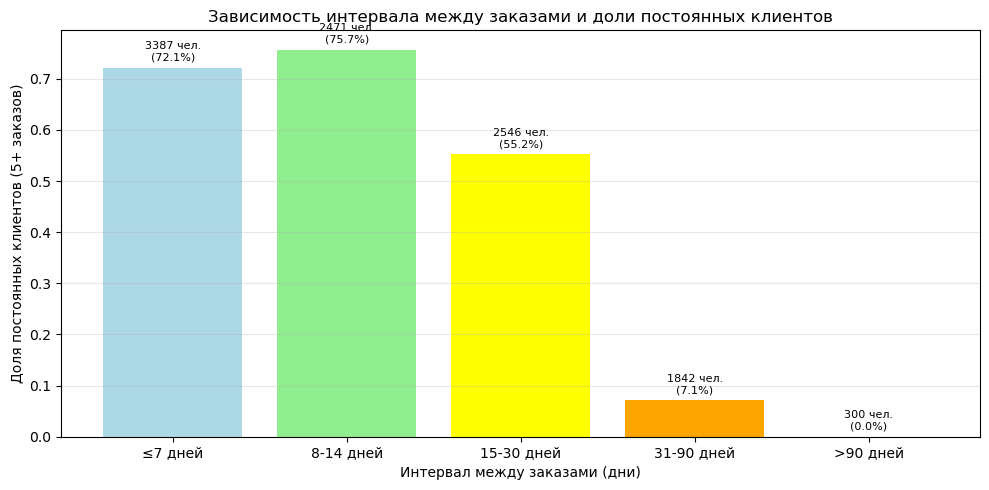

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))

# Фильтруем категории с достаточным количеством пользователей
plot_data = interval_summary[interval_summary['users'] >= 50]

ax.bar(plot_data['interval_cat'], plot_data['const_buyers_share'], 
       color=['lightblue', 'lightgreen', 'yellow', 'orange', 'red'])

ax.set_xlabel('Интервал между заказами (дни)')
ax.set_ylabel('Доля постоянных клиентов (5+ заказов)')
ax.set_title('Зависимость интервала между заказами и доли постоянных клиентов')
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (share, users) in enumerate(zip(plot_data['const_buyers_share'], plot_data['users'])):
    ax.text(i, share + 0.01, f'{users} чел.\n({share:.1%})', 
            ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



**Результаты:**

Средний интервал между заказами сильно влияет на вероятность повторного заказа:

1. Чем меньше интервал между заказами, тем выше вероятность стать постоянным клиентом (5+ заказов)

2. Критический порог для удержания клиента: 14 дней

- <= 14 дней: около 76% пользователей становятся постоянными клиентами
- при большем интервале вероятность начинает снижаться (7% клиентов делают покупку с интервалом 1-3 месяца)

*Рекомендация:* фокусироваться на сокращении интервала между заказами, делать персонализированные предложения в первые 14 дней после заказа. 

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [85]:
# Создаем копию датафрейма для анализа
df_corr = user_profile_filt.copy()

# Сначала исключим ненужные колонки и обработаем данные
# Даты (datetime) нужно исключить или преобразовать, так как они могут иметь много уникальных значений

# Преобразуем дату первого заказа в день недели и месяц первого заказа - категориальные признаки
df_corr['1st_order_weekday'] = df_corr['1st_order_dt'].dt.day_name()
df_corr['1st_order_month'] = df_corr['1st_order_dt'].dt.month_name()

In [86]:
# Колонки для корреляционного анализа
corr_features = ['1st_order_device','1st_order_region','1st_order_service','1st_order_event_type','1st_order_weekday','1st_order_month',      
    'avg_revenue','avg_tickets',
    'total_orders'
] 
# Для анализа всех пользователей не включаем avg_days_between, так как у пользователей с 1 заказом он NaN

# Вычисляем матрицу
correlation_matrix = df_corr[corr_features].phik_matrix(interval_cols= ['avg_revenue','avg_tickets','total_orders'])

corr_with_orders = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной total_orders')
display(corr_with_orders)

Корреляционная матрица с коэффициентом phi_k для переменной total_orders


,total_orders
1st_order_month,0.424087
avg_tickets,0.225904
avg_revenue,0.219482
1st_order_region,0.113663
1st_order_weekday,0.060831
1st_order_event_type,0.027745
1st_order_service,0.027483
1st_order_device,0.025945


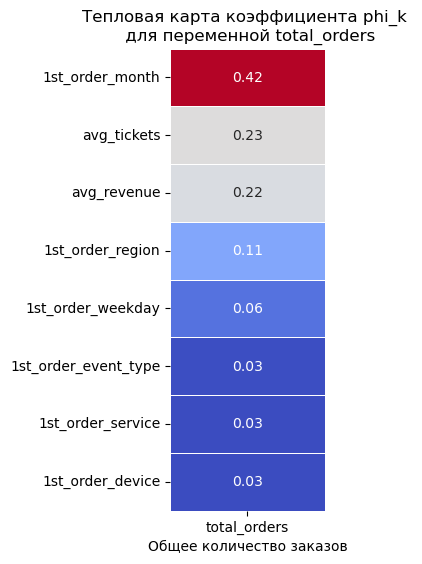

In [87]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

sns.heatmap(corr_with_orders,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для переменной total_orders')
plt.xlabel('Общее количество заказов')

# Выводим график
plt.show()

Наибольшая корреляция числа заказов наблюдается с месяцев первого заказа (`0.42`), средним количеством билетов в заказе(`0.23`) и средней выручкой с одного заказа (`0.22`). Для остальных признаков коэффициент корреляции снижается с `0.11` до `0.03`.

In [88]:
# Создаем сегменты пользователей по количеству заказов 
df_corr['orders_segment'] = pd.cut(df_corr['total_orders'], bins=[0, 1, 4, np.inf],
    labels=['1 заказ', '2-4 заказа', '5+ заказов'], right=True)

# Создаем бинарные признаки лояльности
df_corr['has_repeated'] = (df_corr['total_orders'] > 1).astype(int)
df_corr['is_super_loyal'] = (df_corr['total_orders'] >= 5).astype(int)

# Проверим распределение total_orders
orders_dist = df_corr['total_orders'].value_counts().sort_index()
total_users = len(df_corr)

print(f"Всего пользователей: {total_users}")

# Доля пользователей с 1 заказом
one_order_share = (df_corr['total_orders'] == 1).mean()
print(f"\nДоля пользователей с 1 заказом: {one_order_share:.1%}")

# Распределение по сегментам
print(f"\nРаспределение по сегментам:")
segment_dist = df_corr['orders_segment'].value_counts().sort_index()
for segment, count in segment_dist.items():
    share = count / total_users
    print(f"{segment} : {count} пользователей ({share:.1%})")

Всего пользователей: 21638

Доля пользователей с 1 заказом: 38.7%

Распределение по сегментам:
1 заказ : 8368 пользователей (38.7%)
2-4 заказа : 7147 пользователей (33.0%)
5+ заказов : 6123 пользователей (28.3%)


Распределение по сегментам достаточно сбалансировано. 

Проанализируем корреляции внутри каждого сегмента.


Сегмент: 1 заказ (8368 пользователей)

В сегменте '1 заказ' обнаружены корреляции с phik > 0.3:
1st_order_region ↔ 1st_order_service : 0.67 (Умеренная)
1st_order_service ↔ 1st_order_event_type : 0.58 (Умеренная)
1st_order_region ↔ 1st_order_event_type : 0.50 (Умеренная)
avg_revenue ↔ avg_tickets : 0.46 (Умеренная)
1st_order_service ↔ avg_revenue : 0.45 (Умеренная)
1st_order_region ↔ avg_revenue : 0.40 (Умеренная)
1st_order_event_type ↔ avg_revenue : 0.38 (Умеренная)
1st_order_region ↔ 1st_order_month : 0.32 (Умеренная)

Топ-3 самых сильных корреляций в сегменте '1 заказ':
  1. 1st_order_region vs 1st_order_service: 0.67
  2. 1st_order_service vs 1st_order_event_type: 0.58
  3. 1st_order_region vs 1st_order_event_type: 0.50

Тепловая карта корреляций для сегмента '1 заказ':


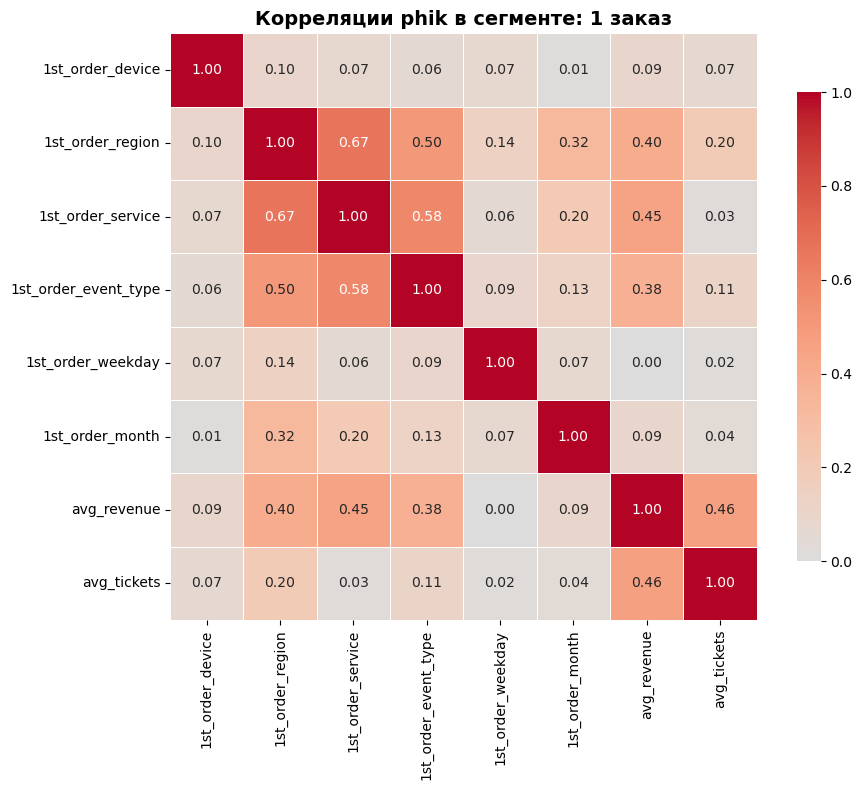


Сегмент: 2-4 заказа (7147 пользователей)

В сегменте '2-4 заказа' обнаружены корреляции с phik > 0.3:
1st_order_region ↔ 1st_order_service : 0.68 (Умеренная)
1st_order_month ↔ avg_days_between : 0.62 (Умеренная)
1st_order_service ↔ 1st_order_event_type : 0.58 (Умеренная)
1st_order_region ↔ 1st_order_event_type : 0.48 (Умеренная)
1st_order_service ↔ avg_revenue : 0.39 (Умеренная)
1st_order_region ↔ 1st_order_month : 0.33 (Умеренная)
1st_order_event_type ↔ avg_revenue : 0.33 (Умеренная)
1st_order_region ↔ avg_revenue : 0.32 (Умеренная)
avg_revenue ↔ avg_tickets : 0.32 (Умеренная)

Топ-3 самых сильных корреляций в сегменте '2-4 заказа':
  1. 1st_order_region vs 1st_order_service: 0.68
  2. 1st_order_month vs avg_days_between: 0.62
  3. 1st_order_service vs 1st_order_event_type: 0.58

Тепловая карта корреляций для сегмента '2-4 заказа':


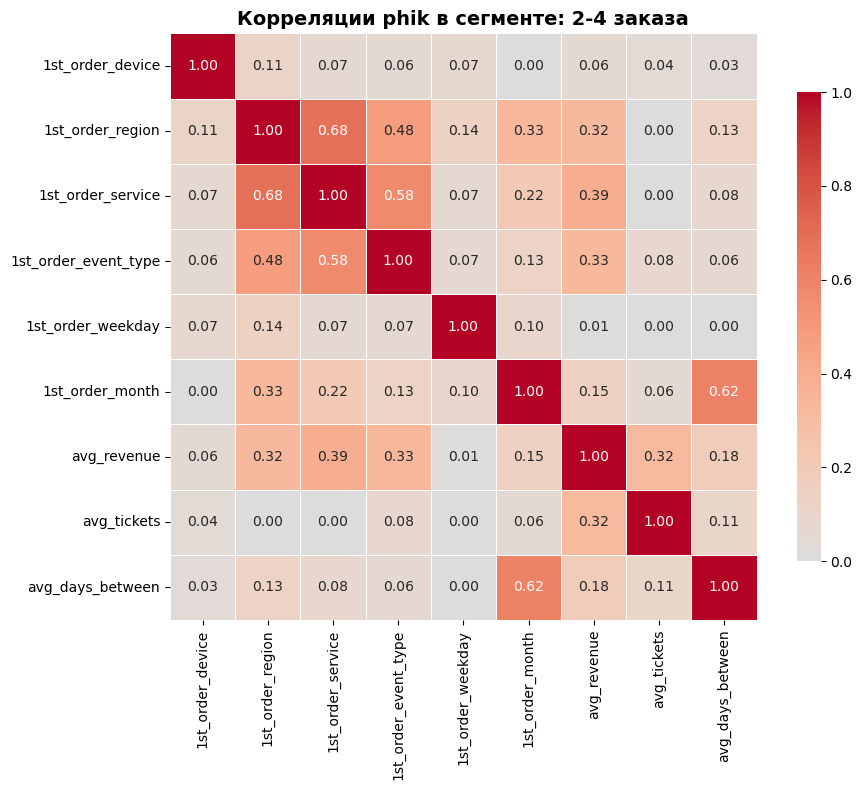


Сегмент: 5+ заказов (6123 пользователей)

В сегменте '5+ заказов' обнаружены корреляции с phik > 0.3:
1st_order_region ↔ 1st_order_service : 0.69 (Умеренная)
1st_order_service ↔ 1st_order_event_type : 0.58 (Умеренная)
1st_order_region ↔ 1st_order_event_type : 0.54 (Умеренная)
1st_order_month ↔ avg_days_between : 0.51 (Умеренная)
1st_order_region ↔ avg_revenue : 0.35 (Умеренная)
avg_revenue ↔ avg_tickets : 0.35 (Умеренная)
1st_order_region ↔ 1st_order_month : 0.33 (Умеренная)
1st_order_month ↔ avg_revenue : 0.33 (Умеренная)

Топ-3 самых сильных корреляций в сегменте '5+ заказов':
  1. 1st_order_region vs 1st_order_service: 0.69
  2. 1st_order_service vs 1st_order_event_type: 0.58
  3. 1st_order_region vs 1st_order_event_type: 0.54

Тепловая карта корреляций для сегмента '5+ заказов':


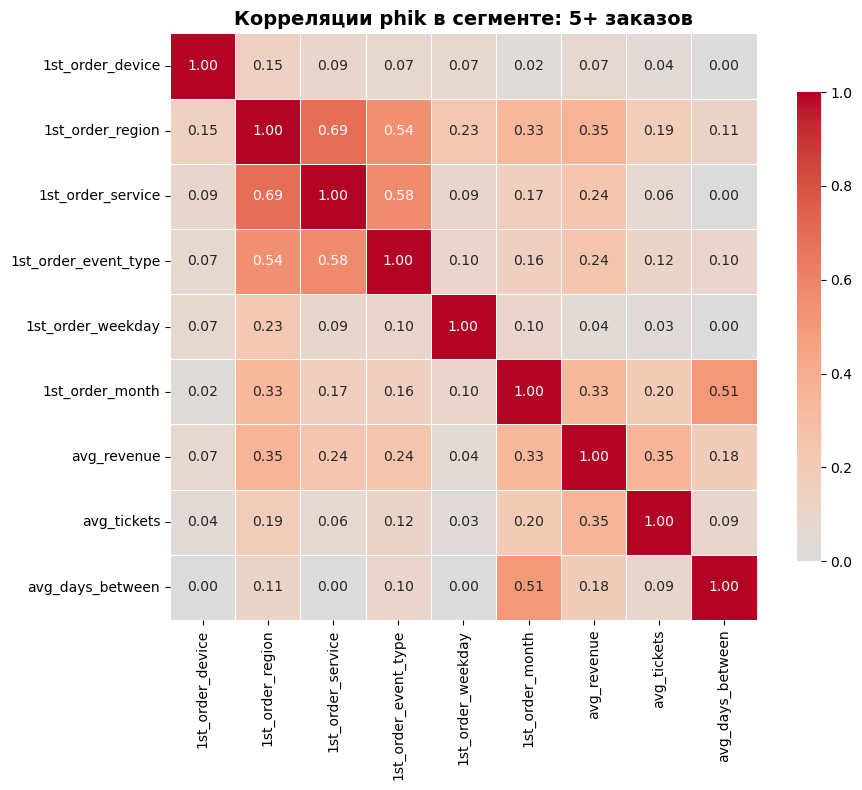

In [89]:
# Колонки для корреляционного анализа (без total_orders)
segment_features = ['1st_order_device','1st_order_region','1st_order_service','1st_order_event_type','1st_order_weekday','1st_order_month',
    'avg_revenue','avg_tickets'
]

# Добавляем avg_days_between для сегментов с повторными заказами
#segment_features_with_interval = segment_features + ['avg_days_between']

# Анализ для каждого сегмента
for segment in ['1 заказ', '2-4 заказа', '5+ заказов']:
    segment_df = df_corr[df_corr['orders_segment'] == segment].copy()
    
    print(f"\nСегмент: {segment} ({len(segment_df)} пользователей)")

    # Определяем признаки для сегмента
    if segment == '1 заказ':
        # Для пользователей с 1 заказом avg_days_between всегда NaN
        features = segment_features
        interval_cols = ['avg_revenue', 'avg_tickets']
    else:
        # Для пользователей с повторными заказами
        features = segment_features + ['avg_days_between']
        interval_cols = ['avg_revenue', 'avg_tickets', 'avg_days_between']
     
            
    # Вычисляем матрицу
    segment_corr = segment_df[features].phik_matrix(interval_cols = interval_cols)


    # Найдем самые сильные корреляции (phik > 0.3)
    strong_correlations = []
    
    for i in range(len(segment_corr.columns)):
        for j in range(i+1, len(segment_corr.columns)):
            corr_value = segment_corr.iloc[i, j]
            if abs(corr_value) > 0.3:  # т.е. это умеренная и сильная корреляция
                feature1 = segment_corr.columns[i]
                feature2 = segment_corr.columns[j]
                strong_correlations.append((feature1, feature2, corr_value))
    
    # Выводим результаты анализа
    if strong_correlations:
        print(f"\nВ сегменте '{segment}' обнаружены корреляции с phik > 0.3:")
               
        # Сортируем по убыванию абсолютного значения корреляции
        for feat1, feat2, corr_val in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
            strength = "Сильная" if abs(corr_val) > 0.7 else "Умеренная" if abs(corr_val) > 0.3 else ""
            print(f"{feat1} ↔ {feat2} : {corr_val:.2f} ({strength})")
    else:
        print(f"\nВ сегменте '{segment}' нет корреляций phik > 0.3")
    
    # Топ-3 самых сильных корреляций
    if strong_correlations:
        print(f"\nТоп-3 самых сильных корреляций в сегменте '{segment}':")
        top_3 = sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True)[:3]
        for idx, (feat1, feat2, corr_val) in enumerate(top_3, 1):
            print(f"  {idx}. {feat1} vs {feat2}: {corr_val:.2f}")
    
    # Тепловая карта 
    print(f"\nТепловая карта корреляций для сегмента '{segment}':")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(segment_corr, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title(f'Корреляции phik в сегменте: {segment}', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

**1. Общий корреляционный анализ (все пользователи):**
   

Наибольшая корреляция числа заказов наблюдается с месяцев первого заказа (`0.42`), средним количеством билетов в заказе (`0.23`) и средней выручкой с одного заказа (`0.22`). 

Признаки первого заказа имеют слабую связь с total_orders (< `0.11`)




**2. Анализ по сегментам пользователей по количеству заказов:**


**Во всех трех сегментах** наблюдаются одинаковые паттерны наибольших корреляций:
     
- регион vs билетный оператор (`0.7`)

- билетный оператор vs тип мероприятия (`0.6`)

- регион vs тип мероприятия (`0.5`)
              

**Сегмент 1 заказ:**
    
- уникальная особенность: умеренная (`0.4`) корреляция выручки (`avg_revenue`) с признаками первого заказа.

  Вывод: для сегмента пользователей с 1 заказом выбор оператора, региона и типа мероприятия умеренно влияет на средний чек.


**Сегмент 2-4 заказа:**

- уникальная особенность: умеренная (`0.6`) корреляция месяца первого заказа и среднего количества дней между заказами.

  Вывод: для сегмента пользователей с 2-4 заказами сезонность (месяц первого заказа) умеренно влияет на частоту последующих покупок


**Сегмент 5+ заказов:**

- самая сильная связь для триады "регион vs билетный оператор vs тип мероприятия"

  Вывод: У самых лояльных пользователей региональные паттерны наиболее выражены, а влияние сезонности уменьшается

### Ответ на вопрос:

1. Прямая связь (phi_k c total_orders):

- Месяц первого заказа (0.42) - самый сильный предиктор. *Это требует проверки, возможен артефакт данных, например, сезонные промо-акции*

- Среднее количество билетов (0.23)

- Средняя выручка (0.22)



2. Косвенная связь (через поведенческие паттерны):

- Для всех пользователей: самая сильная связь для триады "Регион vs Оператор vs Тип мероприятия", т.е. с каналом привлечения.

  *Рекомендация:* разрабатывать маркетинговые стратегии с учетом региональных особенностей.

- Для пользователей c 1 заказом: признаки первого заказа (т.е. канал привлечения) сильно влияют на средний чек

- Для умеренно лояльных пользователей (2-4 заказа): сезонность определяет частоту покупок (возврата).

  *Рекомендация:* планировать маркетинговые активности с учетом сезонности

- Для супер-лояльных (5+ заказов): региональные паттерны наиболее устойчивы

  *Рекомендация:* Дифференцировать маркетинговые подходы для разных сегментов лояльности.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**1. Данные и их подготовка:**

- Проанализировано *21 854 уникальных пользователя* Яндекс Афиши (мобильные и десктопные устройства)
- Данные очищены: выручка приведена к рублям, отфильтрованы аномальные значения (1% ботов/тестовых аккаунтов)
- Сохранены сезонные паттерны (интервалы между заказами до 113 дней)

**2. Ключевая статистика:**

- *62% пользователей* совершают повторные заказы (2+)
- *29% становятся постоянными клиентами* (5+ заказов)
- Средний чек: *544 рубля*, медиана: *413 рублей*
- Типичный пользователь покупает *2-3 билета* за раз

**3. Точки входа:**
**Крупнейшие каналы привлечения:**
- *Мобильные устройства* (83% первых заказов)
- *Концерты* (44%), *Театр* (20%), *Выставки* (высокий возврат 64%)
- *Каменевский регион* (33%), *Североярская область* (17%)
- *Билетные операторы*: "Билеты без проблем" (24%), "Мой билет" (14%)

**Самые перспективные "точки входа"** (много пользователей + возврат выше среднего):
- *Desktop-пользователи* (64% возврата)
- *Театралы и посетители концертов*
- *Регионы*: Каменевский, Североярская и Широковская области
- *Операторы*: "Весь в билетах", "Билеты в руки"

**4. Факторы, влияющие на возврат клиента**
1. **В активных регионах выше лояльность** (+4.4 п.п.)
2. **Размер заказа влияет на возврат**: 
   - Вернувшиеся пользователи тратят в среднем **на 31% больше* (496 руб vs 378 руб)
   - Покупатели 2-3 билетов имеют *74% вероятность вернуться*
3. **Частота покупок критически важна**:
   - Постоянные (5+ заказов) возвращаются каждые *8-10 дней*
   - Умеренно лояльные (2-4 заказа) — каждые *9-21 день*
   - *Критический порог: 14 дней* — после него вероятность стать постоянным падает 

**5. Сильнее всего связано с лояльностью:**
    *Месяц первого заказа* (phik = 0.42) — сезонность ключевой фактор

**Устойчивые паттерны во всех сегментах:**
- *Регион vs Билетный оператор vs Тип мероприятия* (phik = 0.7)
- Это указывает на сформированные каналы привлечения по регионам



**РЕКОМЕНДАЦИИ ДЛЯ БИЗНЕСА**

**Сократить интервал между покупками до 14 дней**
- *0-14 дней после покупки*: Рекомендации похожих мероприятий, персонализированные предложения
- *15+ дней*: Специальные акции для возврата

**Сфокусироваться на перспективных сегментах:**
- *Desktop-пользователи* (высокий возврат 64%)
- *Посетители театров и концертов* (крупные сегменты с хорошим возвратом)
- *Активные регионы*: Каменевский, Североярская, Широковская области

**Региональные стратегии**
- Разрабатывать предложения с учетом локальных предпочтений (оператор и тип мероприятия)
- Усилить присутствие в регионах с высоким возвратом: Шанырский регион, Светополянский округ

**Стимулировать большие заказы**
- Пользователи, покупающие *2-3 билета*, имеют максимальную вероятность возврата (74%)
- *Увеличивать средний чек* — это напрямую влияет на лояльность


**Итог:** Фокус на *сокращении интервалов между покупками*, *увеличении среднего чека* и *региональной адаптации* стратегий позволит значительно повысить лояльность пользователей Яндекс Афиши.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**